# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in TensorFlow.  For example, suppose we are building a biological reinforcement learning model, but we'd like the inputs to our model to be natural images rather than artificial vectors.  We could load a vision network from TensorFlow, insert it into our model using NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the [TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to write code directly in TensorFlow, and then insert it easily into Nengo.  In this example we will demonstrate how to integrate a Keras network into a Nengo model in a series of stages. First, inserting an entire Keras model, second, inserting individual Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import threading

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the node to insert Python code into our model we will use it to insert TensorFlow code.  

The first thing we need to do is define our TensorNode output.  This is a function that accepts the current simulation time (and, optionally, a batch of vectors) as input, and produces a batch of vectors as output.  All of these variables will be represented as `tf.Tensor` objects, and the internal operations of the TensorNode will be implemented with TensorFlow operations. For example, we could use a TensorNode to output a `sin` function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

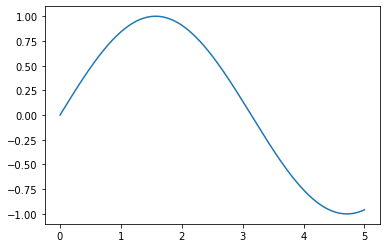

In [2]:
with nengo.Network() as net:
    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)
        
        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))
        
        return output
    
    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)
    
plt.figure()
plt.plot(sim.trange(), sim.data[p]);

However, outputting a `sin` function is something we could do more easily with a regular `nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more complex TensorFlow code and insert it into a NengoDL model. For example, one thing we often want to do is take a deep network written in TensorFlow/Keras, and add it into a Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate) is a popular software package for building and training deep learning style networks.  It is a higher-level API within TensorFlow to make it easier to construct and train deep networks.  And because it is all implemented as a TensorFlow network under the hood, we can define a network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the [introduction in the Tensorflow documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.  This dataset contains images of clothing, and the goal of the network is to identify what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

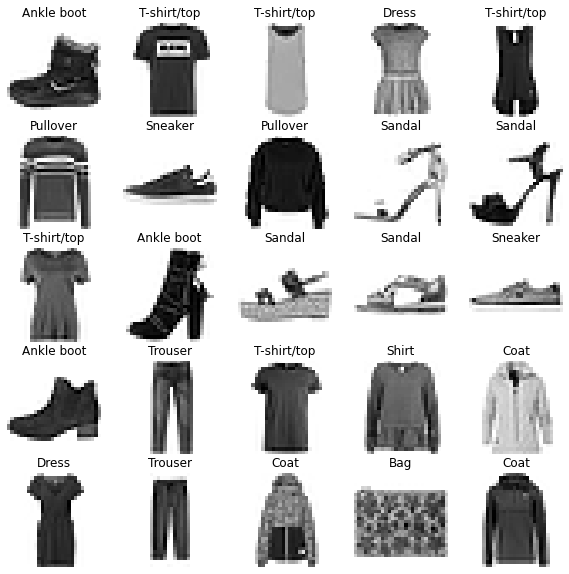

In [3]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.fashion_mnist.load_data())

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(optimizer=tf.optimizers.Adam(), 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Epoch 1/5


   1/1875 [..............................] - ETA: 0s - loss: 2.5408 - accuracy: 0.0938

  31/1875 [..............................] - ETA: 2s - loss: 1.4116 - accuracy: 0.5413

  59/1875 [..............................] - ETA: 3s - loss: 1.1423 - accuracy: 0.6160

  92/1875 [>.............................] - ETA: 2s - loss: 0.9955 - accuracy: 0.6681

 125/1875 [=>............................] - ETA: 2s - loss: 0.9069 - accuracy: 0.6992

 157/1875 [=>............................] - ETA: 2s - loss: 0.8550 - accuracy: 0.7134

 189/1875 [==>...........................] - ETA: 2s - loss: 0.8344 - accuracy: 0.7188

 222/1875 [==>...........................] - ETA: 2s - loss: 0.8029 - accuracy: 0.7292

 256/1875 [===>..........................] - ETA: 2s - loss: 0.7720 - accuracy: 0.7399

 288/1875 [===>..........................] - ETA: 2s - loss: 0.7484 - accuracy: 0.7467

 318/1875 [====>.........................] - ETA: 2s - loss: 0.7323 - accuracy: 0.7518

 349/1875 [====>.........................] - ETA: 2s - loss: 0.7143 - accuracy: 0.7574

 381/1875 [=====>........................] - ETA: 2s - loss: 0.6990 - accuracy: 0.7619

 414/1875 [=====>........................] - ETA: 2s - loss: 0.6839 - accuracy: 0.7671

 446/1875 [======>.......................] - ETA: 2s - loss: 0.6739 - accuracy: 0.7702

 479/1875 [======>.......................] - ETA: 2s - loss: 0.6620 - accuracy: 0.7730

 512/1875 [=======>......................] - ETA: 2s - loss: 0.6536 - accuracy: 0.7748

 545/1875 [=======>......................] - ETA: 2s - loss: 0.6418 - accuracy: 0.7784

 578/1875 [========>.....................] - ETA: 2s - loss: 0.6322 - accuracy: 0.7818

 611/1875 [========>.....................] - ETA: 1s - loss: 0.6247 - accuracy: 0.7845

 643/1875 [=========>....................] - ETA: 1s - loss: 0.6167 - accuracy: 0.7873

 676/1875 [=========>....................] - ETA: 1s - loss: 0.6089 - accuracy: 0.7902

 709/1875 [==========>...................] - ETA: 1s - loss: 0.6040 - accuracy: 0.7916

 742/1875 [==========>...................] - ETA: 1s - loss: 0.5983 - accuracy: 0.7935

 774/1875 [===========>..................] - ETA: 1s - loss: 0.5931 - accuracy: 0.7949

 807/1875 [===========>..................] - ETA: 1s - loss: 0.5891 - accuracy: 0.7961

 838/1875 [============>.................] - ETA: 1s - loss: 0.5852 - accuracy: 0.7970

 871/1875 [============>.................] - ETA: 1s - loss: 0.5810 - accuracy: 0.7986

 903/1875 [=============>................] - ETA: 1s - loss: 0.5772 - accuracy: 0.7994

 936/1875 [=============>................] - ETA: 1s - loss: 0.5738 - accuracy: 0.8008

 967/1875 [==============>...............] - ETA: 1s - loss: 0.5702 - accuracy: 0.8022

 999/1875 [==============>...............] - ETA: 1s - loss: 0.5660 - accuracy: 0.8038

1031/1875 [===============>..............] - ETA: 1s - loss: 0.5616 - accuracy: 0.8057

1064/1875 [================>.............] - ETA: 1s - loss: 0.5580 - accuracy: 0.8066

1096/1875 [================>.............] - ETA: 1s - loss: 0.5546 - accuracy: 0.8077

1127/1875 [=================>............] - ETA: 1s - loss: 0.5516 - accuracy: 0.8086

1158/1875 [=================>............] - ETA: 1s - loss: 0.5481 - accuracy: 0.8098

1190/1875 [==================>...........] - ETA: 1s - loss: 0.5457 - accuracy: 0.8105

1223/1875 [==================>...........] - ETA: 1s - loss: 0.5422 - accuracy: 0.8118

1256/1875 [===================>..........] - ETA: 0s - loss: 0.5393 - accuracy: 0.8125

1284/1875 [===================>..........] - ETA: 0s - loss: 0.5363 - accuracy: 0.8135

1317/1875 [====================>.........] - ETA: 0s - loss: 0.5321 - accuracy: 0.8148

1350/1875 [====================>.........] - ETA: 0s - loss: 0.5293 - accuracy: 0.8156

1383/1875 [=====================>........] - ETA: 0s - loss: 0.5265 - accuracy: 0.8164

1416/1875 [=====================>........] - ETA: 0s - loss: 0.5251 - accuracy: 0.8165

1449/1875 [======================>.......] - ETA: 0s - loss: 0.5227 - accuracy: 0.8172

1482/1875 [======================>.......] - ETA: 0s - loss: 0.5213 - accuracy: 0.8178

1513/1875 [=======================>......] - ETA: 0s - loss: 0.5182 - accuracy: 0.8186

1542/1875 [=======================>......] - ETA: 0s - loss: 0.5162 - accuracy: 0.8192

1571/1875 [========================>.....] - ETA: 0s - loss: 0.5147 - accuracy: 0.8195

1604/1875 [========================>.....] - ETA: 0s - loss: 0.5125 - accuracy: 0.8202

1637/1875 [=========================>....] - ETA: 0s - loss: 0.5101 - accuracy: 0.8211

1669/1875 [=========================>....] - ETA: 0s - loss: 0.5082 - accuracy: 0.8218

1702/1875 [==========================>...] - ETA: 0s - loss: 0.5070 - accuracy: 0.8221

1734/1875 [==========================>...] - ETA: 0s - loss: 0.5050 - accuracy: 0.8227

1767/1875 [===========================>..] - ETA: 0s - loss: 0.5029 - accuracy: 0.8234

1800/1875 [===========================>..] - ETA: 0s - loss: 0.5015 - accuracy: 0.8240

1831/1875 [============================>.] - ETA: 0s - loss: 0.4997 - accuracy: 0.8243

1865/1875 [============================>.] - ETA: 0s - loss: 0.4982 - accuracy: 0.8249

1875/1875 [==============================] - 3s 2ms/step - loss: 0.4979 - accuracy: 0.8251


Epoch 2/5
   1/1875 [..............................] - ETA: 0s - loss: 0.2846 - accuracy: 0.8438

  34/1875 [..............................] - ETA: 2s - loss: 0.4039 - accuracy: 0.8539

  67/1875 [>.............................] - ETA: 2s - loss: 0.3915 - accuracy: 0.8535

 100/1875 [>.............................] - ETA: 2s - loss: 0.3817 - accuracy: 0.8581

 132/1875 [=>............................] - ETA: 2s - loss: 0.3892 - accuracy: 0.8572

 164/1875 [=>............................] - ETA: 2s - loss: 0.3914 - accuracy: 0.8561

 197/1875 [==>...........................] - ETA: 2s - loss: 0.3894 - accuracy: 0.8582

 229/1875 [==>...........................] - ETA: 2s - loss: 0.3871 - accuracy: 0.8614

 262/1875 [===>..........................] - ETA: 2s - loss: 0.3886 - accuracy: 0.8604

 291/1875 [===>..........................] - ETA: 2s - loss: 0.3842 - accuracy: 0.8620

 319/1875 [====>.........................] - ETA: 2s - loss: 0.3860 - accuracy: 0.8612

 352/1875 [====>.........................] - ETA: 2s - loss: 0.3858 - accuracy: 0.8605

 384/1875 [=====>........................] - ETA: 2s - loss: 0.3853 - accuracy: 0.8608

 417/1875 [=====>........................] - ETA: 2s - loss: 0.3858 - accuracy: 0.8617

 450/1875 [======>.......................] - ETA: 2s - loss: 0.3843 - accuracy: 0.8628

 482/1875 [======>.......................] - ETA: 2s - loss: 0.3867 - accuracy: 0.8619

 513/1875 [=======>......................] - ETA: 2s - loss: 0.3857 - accuracy: 0.8610

 545/1875 [=======>......................] - ETA: 2s - loss: 0.3865 - accuracy: 0.8605

 577/1875 [========>.....................] - ETA: 2s - loss: 0.3876 - accuracy: 0.8602

 608/1875 [========>.....................] - ETA: 2s - loss: 0.3865 - accuracy: 0.8601

 641/1875 [=========>....................] - ETA: 1s - loss: 0.3847 - accuracy: 0.8606

 674/1875 [=========>....................] - ETA: 1s - loss: 0.3828 - accuracy: 0.8621

 707/1875 [==========>...................] - ETA: 1s - loss: 0.3817 - accuracy: 0.8624

 739/1875 [==========>...................] - ETA: 1s - loss: 0.3808 - accuracy: 0.8625

 771/1875 [===========>..................] - ETA: 1s - loss: 0.3804 - accuracy: 0.8622

 804/1875 [===========>..................] - ETA: 1s - loss: 0.3806 - accuracy: 0.8621

 828/1875 [============>.................] - ETA: 1s - loss: 0.3816 - accuracy: 0.8615

 860/1875 [============>.................] - ETA: 1s - loss: 0.3820 - accuracy: 0.8614

 891/1875 [=============>................] - ETA: 1s - loss: 0.3813 - accuracy: 0.8615

 923/1875 [=============>................] - ETA: 1s - loss: 0.3796 - accuracy: 0.8621

 956/1875 [==============>...............] - ETA: 1s - loss: 0.3793 - accuracy: 0.8623

 988/1875 [==============>...............] - ETA: 1s - loss: 0.3793 - accuracy: 0.8622

1021/1875 [===============>..............] - ETA: 1s - loss: 0.3784 - accuracy: 0.8626

1053/1875 [===============>..............] - ETA: 1s - loss: 0.3779 - accuracy: 0.8627

1086/1875 [================>.............] - ETA: 1s - loss: 0.3778 - accuracy: 0.8625

1115/1875 [================>.............] - ETA: 1s - loss: 0.3778 - accuracy: 0.8626

1147/1875 [=================>............] - ETA: 1s - loss: 0.3764 - accuracy: 0.8633

1180/1875 [=================>............] - ETA: 1s - loss: 0.3767 - accuracy: 0.8628

1213/1875 [==================>...........] - ETA: 1s - loss: 0.3757 - accuracy: 0.8631

1246/1875 [==================>...........] - ETA: 1s - loss: 0.3748 - accuracy: 0.8638

1279/1875 [===================>..........] - ETA: 0s - loss: 0.3746 - accuracy: 0.8637

1312/1875 [===================>..........] - ETA: 0s - loss: 0.3743 - accuracy: 0.8638

1345/1875 [====================>.........] - ETA: 0s - loss: 0.3755 - accuracy: 0.8635

1378/1875 [=====================>........] - ETA: 0s - loss: 0.3750 - accuracy: 0.8640

1411/1875 [=====================>........] - ETA: 0s - loss: 0.3747 - accuracy: 0.8640

1443/1875 [======================>.......] - ETA: 0s - loss: 0.3737 - accuracy: 0.8643

1476/1875 [======================>.......] - ETA: 0s - loss: 0.3736 - accuracy: 0.8640

1509/1875 [=======================>......] - ETA: 0s - loss: 0.3737 - accuracy: 0.8643

1542/1875 [=======================>......] - ETA: 0s - loss: 0.3746 - accuracy: 0.8641

1574/1875 [========================>.....] - ETA: 0s - loss: 0.3744 - accuracy: 0.8642

1607/1875 [========================>.....] - ETA: 0s - loss: 0.3732 - accuracy: 0.8647

1640/1875 [=========================>....] - ETA: 0s - loss: 0.3732 - accuracy: 0.8648

1671/1875 [=========================>....] - ETA: 0s - loss: 0.3725 - accuracy: 0.8652

1703/1875 [==========================>...] - ETA: 0s - loss: 0.3725 - accuracy: 0.8653

1736/1875 [==========================>...] - ETA: 0s - loss: 0.3717 - accuracy: 0.8656

1768/1875 [===========================>..] - ETA: 0s - loss: 0.3712 - accuracy: 0.8659

1800/1875 [===========================>..] - ETA: 0s - loss: 0.3713 - accuracy: 0.8659

1833/1875 [============================>.] - ETA: 0s - loss: 0.3709 - accuracy: 0.8662

1865/1875 [============================>.] - ETA: 0s - loss: 0.3706 - accuracy: 0.8664

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3706 - accuracy: 0.8663


Epoch 3/5
   1/1875 [..............................] - ETA: 0s - loss: 0.4551 - accuracy: 0.9375

  33/1875 [..............................] - ETA: 2s - loss: 0.3202 - accuracy: 0.8949

  66/1875 [>.............................] - ETA: 2s - loss: 0.3421 - accuracy: 0.8769

  99/1875 [>.............................] - ETA: 2s - loss: 0.3321 - accuracy: 0.8819

 126/1875 [=>............................] - ETA: 2s - loss: 0.3333 - accuracy: 0.8814

 159/1875 [=>............................] - ETA: 2s - loss: 0.3297 - accuracy: 0.8821

 192/1875 [==>...........................] - ETA: 2s - loss: 0.3363 - accuracy: 0.8779

 225/1875 [==>...........................] - ETA: 2s - loss: 0.3332 - accuracy: 0.8775

 255/1875 [===>..........................] - ETA: 2s - loss: 0.3319 - accuracy: 0.8798

 283/1875 [===>..........................] - ETA: 2s - loss: 0.3380 - accuracy: 0.8781

 316/1875 [====>.........................] - ETA: 2s - loss: 0.3432 - accuracy: 0.8759

 348/1875 [====>.........................] - ETA: 2s - loss: 0.3438 - accuracy: 0.8763

 374/1875 [====>.........................] - ETA: 2s - loss: 0.3456 - accuracy: 0.8753

 407/1875 [=====>........................] - ETA: 2s - loss: 0.3449 - accuracy: 0.8745

 438/1875 [======>.......................] - ETA: 2s - loss: 0.3436 - accuracy: 0.8750

 466/1875 [======>.......................] - ETA: 2s - loss: 0.3400 - accuracy: 0.8756

 498/1875 [======>.......................] - ETA: 2s - loss: 0.3379 - accuracy: 0.8759

 531/1875 [=======>......................] - ETA: 2s - loss: 0.3379 - accuracy: 0.8768

 564/1875 [========>.....................] - ETA: 2s - loss: 0.3378 - accuracy: 0.8770

 596/1875 [========>.....................] - ETA: 2s - loss: 0.3398 - accuracy: 0.8763

 629/1875 [=========>....................] - ETA: 2s - loss: 0.3397 - accuracy: 0.8761

 662/1875 [=========>....................] - ETA: 1s - loss: 0.3407 - accuracy: 0.8757

 695/1875 [==========>...................] - ETA: 1s - loss: 0.3432 - accuracy: 0.8750

 728/1875 [==========>...................] - ETA: 1s - loss: 0.3424 - accuracy: 0.8753

 760/1875 [===========>..................] - ETA: 1s - loss: 0.3401 - accuracy: 0.8759

 787/1875 [===========>..................] - ETA: 1s - loss: 0.3383 - accuracy: 0.8763

 820/1875 [============>.................] - ETA: 1s - loss: 0.3368 - accuracy: 0.8771

 848/1875 [============>.................] - ETA: 1s - loss: 0.3386 - accuracy: 0.8759

 880/1875 [=============>................] - ETA: 1s - loss: 0.3375 - accuracy: 0.8763

 912/1875 [=============>................] - ETA: 1s - loss: 0.3365 - accuracy: 0.8767

 945/1875 [==============>...............] - ETA: 1s - loss: 0.3372 - accuracy: 0.8768

 977/1875 [==============>...............] - ETA: 1s - loss: 0.3350 - accuracy: 0.8778

1010/1875 [===============>..............] - ETA: 1s - loss: 0.3352 - accuracy: 0.8774

1042/1875 [===============>..............] - ETA: 1s - loss: 0.3357 - accuracy: 0.8772

1073/1875 [================>.............] - ETA: 1s - loss: 0.3352 - accuracy: 0.8775

1106/1875 [================>.............] - ETA: 1s - loss: 0.3358 - accuracy: 0.8774

1139/1875 [=================>............] - ETA: 1s - loss: 0.3349 - accuracy: 0.8777

1172/1875 [=================>............] - ETA: 1s - loss: 0.3347 - accuracy: 0.8776

1205/1875 [==================>...........] - ETA: 1s - loss: 0.3350 - accuracy: 0.8775

1238/1875 [==================>...........] - ETA: 1s - loss: 0.3346 - accuracy: 0.8776

1271/1875 [===================>..........] - ETA: 0s - loss: 0.3352 - accuracy: 0.8770

1303/1875 [===================>..........] - ETA: 0s - loss: 0.3344 - accuracy: 0.8777

1336/1875 [====================>.........] - ETA: 0s - loss: 0.3338 - accuracy: 0.8779

1346/1875 [====================>.........] - ETA: 0s - loss: 0.3347 - accuracy: 0.8775

1368/1875 [====================>.........] - ETA: 0s - loss: 0.3348 - accuracy: 0.8772

1400/1875 [=====================>........] - ETA: 0s - loss: 0.3360 - accuracy: 0.8771

1432/1875 [=====================>........] - ETA: 0s - loss: 0.3361 - accuracy: 0.8772

1464/1875 [======================>.......] - ETA: 0s - loss: 0.3358 - accuracy: 0.8774

1493/1875 [======================>.......] - ETA: 0s - loss: 0.3352 - accuracy: 0.8777

1524/1875 [=======================>......] - ETA: 0s - loss: 0.3347 - accuracy: 0.8779

1557/1875 [=======================>......] - ETA: 0s - loss: 0.3343 - accuracy: 0.8781

1589/1875 [========================>.....] - ETA: 0s - loss: 0.3348 - accuracy: 0.8779

1622/1875 [========================>.....] - ETA: 0s - loss: 0.3344 - accuracy: 0.8781

1654/1875 [=========================>....] - ETA: 0s - loss: 0.3345 - accuracy: 0.8782

1687/1875 [=========================>....] - ETA: 0s - loss: 0.3341 - accuracy: 0.8783

1720/1875 [==========================>...] - ETA: 0s - loss: 0.3334 - accuracy: 0.8785

1753/1875 [===========================>..] - ETA: 0s - loss: 0.3333 - accuracy: 0.8783

1786/1875 [===========================>..] - ETA: 0s - loss: 0.3339 - accuracy: 0.8782

1819/1875 [============================>.] - ETA: 0s - loss: 0.3330 - accuracy: 0.8786

1851/1875 [============================>.] - ETA: 0s - loss: 0.3322 - accuracy: 0.8787

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3319 - accuracy: 0.8787


Epoch 4/5
   1/1875 [..............................] - ETA: 0s - loss: 0.4428 - accuracy: 0.8750

  34/1875 [..............................] - ETA: 2s - loss: 0.3173 - accuracy: 0.8860

  67/1875 [>.............................] - ETA: 2s - loss: 0.3206 - accuracy: 0.8913

 100/1875 [>.............................] - ETA: 2s - loss: 0.3238 - accuracy: 0.8891

 133/1875 [=>............................] - ETA: 2s - loss: 0.3203 - accuracy: 0.8879

 165/1875 [=>............................] - ETA: 2s - loss: 0.3238 - accuracy: 0.8858

 196/1875 [==>...........................] - ETA: 2s - loss: 0.3157 - accuracy: 0.8865

 229/1875 [==>...........................] - ETA: 2s - loss: 0.3109 - accuracy: 0.8885

 258/1875 [===>..........................] - ETA: 2s - loss: 0.3133 - accuracy: 0.8886

 287/1875 [===>..........................] - ETA: 2s - loss: 0.3155 - accuracy: 0.8868

 318/1875 [====>.........................] - ETA: 2s - loss: 0.3144 - accuracy: 0.8870

 349/1875 [====>.........................] - ETA: 2s - loss: 0.3186 - accuracy: 0.8839

 381/1875 [=====>........................] - ETA: 2s - loss: 0.3174 - accuracy: 0.8842

 414/1875 [=====>........................] - ETA: 2s - loss: 0.3160 - accuracy: 0.8848

 447/1875 [======>.......................] - ETA: 2s - loss: 0.3149 - accuracy: 0.8846

 478/1875 [======>.......................] - ETA: 2s - loss: 0.3141 - accuracy: 0.8852

 511/1875 [=======>......................] - ETA: 2s - loss: 0.3140 - accuracy: 0.8848

 544/1875 [=======>......................] - ETA: 2s - loss: 0.3153 - accuracy: 0.8841

 577/1875 [========>.....................] - ETA: 2s - loss: 0.3132 - accuracy: 0.8846

 609/1875 [========>.....................] - ETA: 2s - loss: 0.3127 - accuracy: 0.8845

 640/1875 [=========>....................] - ETA: 1s - loss: 0.3137 - accuracy: 0.8845

 673/1875 [=========>....................] - ETA: 1s - loss: 0.3140 - accuracy: 0.8851

 701/1875 [==========>...................] - ETA: 1s - loss: 0.3125 - accuracy: 0.8856

 733/1875 [==========>...................] - ETA: 1s - loss: 0.3126 - accuracy: 0.8857

 766/1875 [===========>..................] - ETA: 1s - loss: 0.3127 - accuracy: 0.8860

 799/1875 [===========>..................] - ETA: 1s - loss: 0.3131 - accuracy: 0.8859

 832/1875 [============>.................] - ETA: 1s - loss: 0.3133 - accuracy: 0.8861

 864/1875 [============>.................] - ETA: 1s - loss: 0.3126 - accuracy: 0.8864

 895/1875 [=============>................] - ETA: 1s - loss: 0.3120 - accuracy: 0.8867

 928/1875 [=============>................] - ETA: 1s - loss: 0.3105 - accuracy: 0.8871

 960/1875 [==============>...............] - ETA: 1s - loss: 0.3112 - accuracy: 0.8868

 993/1875 [==============>...............] - ETA: 1s - loss: 0.3101 - accuracy: 0.8871

1024/1875 [===============>..............] - ETA: 1s - loss: 0.3096 - accuracy: 0.8871

1056/1875 [===============>..............] - ETA: 1s - loss: 0.3088 - accuracy: 0.8872

1089/1875 [================>.............] - ETA: 1s - loss: 0.3087 - accuracy: 0.8873

1121/1875 [================>.............] - ETA: 1s - loss: 0.3098 - accuracy: 0.8871

1153/1875 [=================>............] - ETA: 1s - loss: 0.3098 - accuracy: 0.8873

1186/1875 [=================>............] - ETA: 1s - loss: 0.3085 - accuracy: 0.8876

1219/1875 [==================>...........] - ETA: 1s - loss: 0.3082 - accuracy: 0.8875

1252/1875 [===================>..........] - ETA: 0s - loss: 0.3078 - accuracy: 0.8877

1285/1875 [===================>..........] - ETA: 0s - loss: 0.3066 - accuracy: 0.8881

1318/1875 [====================>.........] - ETA: 0s - loss: 0.3073 - accuracy: 0.8876

1350/1875 [====================>.........] - ETA: 0s - loss: 0.3074 - accuracy: 0.8875

1383/1875 [=====================>........] - ETA: 0s - loss: 0.3083 - accuracy: 0.8872

1416/1875 [=====================>........] - ETA: 0s - loss: 0.3082 - accuracy: 0.8873

1447/1875 [======================>.......] - ETA: 0s - loss: 0.3085 - accuracy: 0.8871

1480/1875 [======================>.......] - ETA: 0s - loss: 0.3092 - accuracy: 0.8869

1513/1875 [=======================>......] - ETA: 0s - loss: 0.3085 - accuracy: 0.8870

1545/1875 [=======================>......] - ETA: 0s - loss: 0.3086 - accuracy: 0.8870

1576/1875 [========================>.....] - ETA: 0s - loss: 0.3088 - accuracy: 0.8869

1609/1875 [========================>.....] - ETA: 0s - loss: 0.3090 - accuracy: 0.8868

1642/1875 [=========================>....] - ETA: 0s - loss: 0.3078 - accuracy: 0.8870

1674/1875 [=========================>....] - ETA: 0s - loss: 0.3084 - accuracy: 0.8870

1707/1875 [==========================>...] - ETA: 0s - loss: 0.3090 - accuracy: 0.8869

1740/1875 [==========================>...] - ETA: 0s - loss: 0.3094 - accuracy: 0.8868

1767/1875 [===========================>..] - ETA: 0s - loss: 0.3094 - accuracy: 0.8868

1799/1875 [===========================>..] - ETA: 0s - loss: 0.3093 - accuracy: 0.8867

1829/1875 [============================>.] - ETA: 0s - loss: 0.3092 - accuracy: 0.8867

1861/1875 [============================>.] - ETA: 0s - loss: 0.3088 - accuracy: 0.8866

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3087 - accuracy: 0.8866


Epoch 5/5
   1/1875 [..............................] - ETA: 0s - loss: 0.1173 - accuracy: 0.9688

  34/1875 [..............................] - ETA: 2s - loss: 0.3161 - accuracy: 0.8851

  65/1875 [>.............................] - ETA: 2s - loss: 0.3047 - accuracy: 0.8894

  97/1875 [>.............................] - ETA: 2s - loss: 0.2937 - accuracy: 0.8940

 129/1875 [=>............................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8934

 160/1875 [=>............................] - ETA: 2s - loss: 0.2922 - accuracy: 0.8945

 193/1875 [==>...........................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8956

 225/1875 [==>...........................] - ETA: 2s - loss: 0.2916 - accuracy: 0.8956

 258/1875 [===>..........................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8951

 290/1875 [===>..........................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8946

 322/1875 [====>.........................] - ETA: 2s - loss: 0.2949 - accuracy: 0.8935

 355/1875 [====>.........................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8934

 388/1875 [=====>........................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8942

 420/1875 [=====>........................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8936

 453/1875 [======>.......................] - ETA: 2s - loss: 0.2938 - accuracy: 0.8934

 486/1875 [======>.......................] - ETA: 2s - loss: 0.2917 - accuracy: 0.8934

 517/1875 [=======>......................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8929

 549/1875 [=======>......................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8925

 582/1875 [========>.....................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8919

 615/1875 [========>.....................] - ETA: 1s - loss: 0.2910 - accuracy: 0.8928

 648/1875 [=========>....................] - ETA: 1s - loss: 0.2910 - accuracy: 0.8922

 679/1875 [=========>....................] - ETA: 1s - loss: 0.2921 - accuracy: 0.8918

 712/1875 [==========>...................] - ETA: 1s - loss: 0.2908 - accuracy: 0.8923

 744/1875 [==========>...................] - ETA: 1s - loss: 0.2923 - accuracy: 0.8917

 777/1875 [===========>..................] - ETA: 1s - loss: 0.2923 - accuracy: 0.8916

 809/1875 [===========>..................] - ETA: 1s - loss: 0.2917 - accuracy: 0.8922

 842/1875 [============>.................] - ETA: 1s - loss: 0.2905 - accuracy: 0.8926

 875/1875 [=============>................] - ETA: 1s - loss: 0.2901 - accuracy: 0.8925

 908/1875 [=============>................] - ETA: 1s - loss: 0.2894 - accuracy: 0.8922

 940/1875 [==============>...............] - ETA: 1s - loss: 0.2895 - accuracy: 0.8923

 973/1875 [==============>...............] - ETA: 1s - loss: 0.2896 - accuracy: 0.8926

1006/1875 [===============>..............] - ETA: 1s - loss: 0.2907 - accuracy: 0.8924

1039/1875 [===============>..............] - ETA: 1s - loss: 0.2898 - accuracy: 0.8928

1071/1875 [================>.............] - ETA: 1s - loss: 0.2904 - accuracy: 0.8927

1094/1875 [================>.............] - ETA: 1s - loss: 0.2899 - accuracy: 0.8931

1126/1875 [=================>............] - ETA: 1s - loss: 0.2906 - accuracy: 0.8925

1158/1875 [=================>............] - ETA: 1s - loss: 0.2896 - accuracy: 0.8928

1191/1875 [==================>...........] - ETA: 1s - loss: 0.2898 - accuracy: 0.8926

1223/1875 [==================>...........] - ETA: 1s - loss: 0.2904 - accuracy: 0.8926

1255/1875 [===================>..........] - ETA: 0s - loss: 0.2915 - accuracy: 0.8921

1288/1875 [===================>..........] - ETA: 0s - loss: 0.2911 - accuracy: 0.8921

1321/1875 [====================>.........] - ETA: 0s - loss: 0.2906 - accuracy: 0.8922

1354/1875 [====================>.........] - ETA: 0s - loss: 0.2921 - accuracy: 0.8915

1387/1875 [=====================>........] - ETA: 0s - loss: 0.2927 - accuracy: 0.8913

1420/1875 [=====================>........] - ETA: 0s - loss: 0.2921 - accuracy: 0.8914

1451/1875 [======================>.......] - ETA: 0s - loss: 0.2918 - accuracy: 0.8915

1483/1875 [======================>.......] - ETA: 0s - loss: 0.2914 - accuracy: 0.8915

1516/1875 [=======================>......] - ETA: 0s - loss: 0.2922 - accuracy: 0.8914

1549/1875 [=======================>......] - ETA: 0s - loss: 0.2919 - accuracy: 0.8914

1581/1875 [========================>.....] - ETA: 0s - loss: 0.2922 - accuracy: 0.8914

1614/1875 [========================>.....] - ETA: 0s - loss: 0.2921 - accuracy: 0.8914

1644/1875 [=========================>....] - ETA: 0s - loss: 0.2931 - accuracy: 0.8908

1674/1875 [=========================>....] - ETA: 0s - loss: 0.2926 - accuracy: 0.8911

1701/1875 [==========================>...] - ETA: 0s - loss: 0.2931 - accuracy: 0.8909

1734/1875 [==========================>...] - ETA: 0s - loss: 0.2930 - accuracy: 0.8911

1762/1875 [===========================>..] - ETA: 0s - loss: 0.2932 - accuracy: 0.8911

1795/1875 [===========================>..] - ETA: 0s - loss: 0.2932 - accuracy: 0.8911

1828/1875 [============================>.] - ETA: 0s - loss: 0.2927 - accuracy: 0.8912

1861/1875 [============================>.] - ETA: 0s - loss: 0.2929 - accuracy: 0.8910

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2925 - accuracy: 0.8913


Test accuracy: 0.8671000003814697


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more complicated in this case, since we need to load in the model from above and the pretrained weights.  We can accomplish this by creating a custom Keras Layer, which allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This effectively reruns the Keras model definition from above, but because we're calling it within the `build` stage it will be naturally integrated into the NengoDL model that is being built.

The `call` function is where we do the main job of constructing the TensorFlow elements that will implement our node.  It will take TensorFlow Tensors as input and produce a `tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()
        
        self.model = keras_model
        
    def build(self, input_shapes):
        super().build(input_shapes)
        
        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)
        
        # load the weights we saved above
        self.model.load_weights(model_weights)
        
        # this part is just for compatibility between different
        # TensorFlow versions
        if not hasattr(self.model, "_metrics_lock"):
            self.model._metrics_lock = threading.Lock()
            for lay in self.model.layers:
                lay._metrics_lock = threading.Lock()
        
    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)
    
    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28*28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and connect them up to the Keras node (for example, if we wanted to take the classified image labels and use them as input to a spiking neural model).  But to keep things simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

| #                       Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Test accuracy: 0.8671


We can see that we're getting the same performance in Nengo as we were in Keras, indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to integrate a Keras model into Nengo by inserting the individual layers.  This requires more manual translation work, but it makes it easier to make changes to the model later on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to the TensorNode.  However, we can make this construction process even simpler by using `nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the Keras functional layer API. Under the hood it's doing the same thing (creating TensorNodes and Connections), but it allows us to define the model in a way that looks very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(
        tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(inp)
    out = nengo_dl.Layer(
        tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL this time. Fortunately, the API is essentially the same:

In [11]:
# we'll disable some features we don't need in this example, to improve
# the training speed
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Train on 60000 samples


Epoch 1/5
   20/60000 [..............................] - ETA: 0s - loss: 2.3175 - probe_loss: 2.3175 - probe_accuracy: 0.1000

  660/60000 [..............................] - ETA: 4s - loss: 1.5270 - probe_loss: 1.5270 - probe_accuracy: 0.4606

 1300/60000 [..............................] - ETA: 4s - loss: 1.2335 - probe_loss: 1.2335 - probe_accuracy: 0.5562

 1960/60000 [..............................] - ETA: 4s - loss: 1.0688 - probe_loss: 1.0688 - probe_accuracy: 0.6128

 2620/60000 [>.............................] - ETA: 4s - loss: 0.9754 - probe_loss: 0.9754 - probe_accuracy: 0.6523

 3280/60000 [>.............................] - ETA: 4s - loss: 0.9350 - probe_loss: 0.9350 - probe_accuracy: 0.6677

 3820/60000 [>.............................] - ETA: 4s - loss: 0.8917 - probe_loss: 0.8917 - probe_accuracy: 0.6846

 4420/60000 [=>............................] - ETA: 4s - loss: 0.8646 - probe_loss: 0.8646 - probe_accuracy: 0.6937

 5080/60000 [=>............................] - ETA: 4s - loss: 0.8335 - probe_loss: 0.8335 - probe_accuracy: 0.7049

 5660/60000 [=>............................] - ETA: 4s - loss: 0.8062 - probe_loss: 0.8062 - probe_accuracy: 0.7129

 6320/60000 [==>...........................] - ETA: 4s - loss: 0.7831 - probe_loss: 0.7831 - probe_accuracy: 0.7220

 6960/60000 [==>...........................] - ETA: 4s - loss: 0.7635 - probe_loss: 0.7635 - probe_accuracy: 0.7293

 7620/60000 [==>...........................] - ETA: 4s - loss: 0.7422 - probe_loss: 0.7422 - probe_accuracy: 0.7367

 8260/60000 [===>..........................] - ETA: 4s - loss: 0.7291 - probe_loss: 0.7291 - probe_accuracy: 0.7419

 8920/60000 [===>..........................] - ETA: 4s - loss: 0.7142 - probe_loss: 0.7142 - probe_accuracy: 0.7471

 9500/60000 [===>..........................] - ETA: 4s - loss: 0.7043 - probe_loss: 0.7043 - probe_accuracy: 0.7512

10160/60000 [====>.........................] - ETA: 3s - loss: 0.6930 - probe_loss: 0.6930 - probe_accuracy: 0.7543

10820/60000 [====>.........................] - ETA: 3s - loss: 0.6879 - probe_loss: 0.6879 - probe_accuracy: 0.7555

11480/60000 [====>.........................] - ETA: 3s - loss: 0.6795 - probe_loss: 0.6795 - probe_accuracy: 0.7598

12140/60000 [=====>........................] - ETA: 3s - loss: 0.6702 - probe_loss: 0.6702 - probe_accuracy: 0.7631

12800/60000 [=====>........................] - ETA: 3s - loss: 0.6653 - probe_loss: 0.6653 - probe_accuracy: 0.7648

13460/60000 [=====>........................] - ETA: 3s - loss: 0.6554 - probe_loss: 0.6554 - probe_accuracy: 0.7686

14100/60000 [======>.......................] - ETA: 3s - loss: 0.6488 - probe_loss: 0.6488 - probe_accuracy: 0.7704

14760/60000 [======>.......................] - ETA: 3s - loss: 0.6461 - probe_loss: 0.6461 - probe_accuracy: 0.7715

15420/60000 [======>.......................] - ETA: 3s - loss: 0.6399 - probe_loss: 0.6399 - probe_accuracy: 0.7742

16080/60000 [=======>......................] - ETA: 3s - loss: 0.6354 - probe_loss: 0.6354 - probe_accuracy: 0.7756

16720/60000 [=======>......................] - ETA: 3s - loss: 0.6301 - probe_loss: 0.6301 - probe_accuracy: 0.7781

17220/60000 [=======>......................] - ETA: 3s - loss: 0.6268 - probe_loss: 0.6268 - probe_accuracy: 0.7794

17860/60000 [=======>......................] - ETA: 3s - loss: 0.6220 - probe_loss: 0.6220 - probe_accuracy: 0.7811

18520/60000 [========>.....................] - ETA: 3s - loss: 0.6165 - probe_loss: 0.6165 - probe_accuracy: 0.7832

19180/60000 [========>.....................] - ETA: 3s - loss: 0.6118 - probe_loss: 0.6118 - probe_accuracy: 0.7852

19780/60000 [========>.....................] - ETA: 3s - loss: 0.6084 - probe_loss: 0.6084 - probe_accuracy: 0.7863

20420/60000 [=========>....................] - ETA: 3s - loss: 0.6037 - probe_loss: 0.6037 - probe_accuracy: 0.7876

21080/60000 [=========>....................] - ETA: 3s - loss: 0.5982 - probe_loss: 0.5982 - probe_accuracy: 0.7895

21740/60000 [=========>....................] - ETA: 3s - loss: 0.5938 - probe_loss: 0.5938 - probe_accuracy: 0.7911

22400/60000 [==========>...................] - ETA: 2s - loss: 0.5909 - probe_loss: 0.5909 - probe_accuracy: 0.7919

23060/60000 [==========>...................] - ETA: 2s - loss: 0.5868 - probe_loss: 0.5868 - probe_accuracy: 0.7934

23720/60000 [==========>...................] - ETA: 2s - loss: 0.5832 - probe_loss: 0.5832 - probe_accuracy: 0.7948

24380/60000 [===========>..................] - ETA: 2s - loss: 0.5792 - probe_loss: 0.5792 - probe_accuracy: 0.7962

24980/60000 [===========>..................] - ETA: 2s - loss: 0.5759 - probe_loss: 0.5759 - probe_accuracy: 0.7973

25500/60000 [===========>..................] - ETA: 2s - loss: 0.5735 - probe_loss: 0.5735 - probe_accuracy: 0.7979

26040/60000 [============>.................] - ETA: 2s - loss: 0.5722 - probe_loss: 0.5722 - probe_accuracy: 0.7985

26400/60000 [============>.................] - ETA: 2s - loss: 0.5702 - probe_loss: 0.5702 - probe_accuracy: 0.7991

27020/60000 [============>.................] - ETA: 2s - loss: 0.5676 - probe_loss: 0.5676 - probe_accuracy: 0.8000

27680/60000 [============>.................] - ETA: 2s - loss: 0.5650 - probe_loss: 0.5650 - probe_accuracy: 0.8010

28320/60000 [=============>................] - ETA: 2s - loss: 0.5624 - probe_loss: 0.5624 - probe_accuracy: 0.8021

28960/60000 [=============>................] - ETA: 2s - loss: 0.5608 - probe_loss: 0.5608 - probe_accuracy: 0.8030

29560/60000 [=============>................] - ETA: 2s - loss: 0.5587 - probe_loss: 0.5587 - probe_accuracy: 0.8038

30220/60000 [==============>...............] - ETA: 2s - loss: 0.5581 - probe_loss: 0.5581 - probe_accuracy: 0.8038

30880/60000 [==============>...............] - ETA: 2s - loss: 0.5559 - probe_loss: 0.5559 - probe_accuracy: 0.8045

31380/60000 [==============>...............] - ETA: 2s - loss: 0.5556 - probe_loss: 0.5556 - probe_accuracy: 0.8047

32000/60000 [===============>..............] - ETA: 2s - loss: 0.5538 - probe_loss: 0.5538 - probe_accuracy: 0.8053

32640/60000 [===============>..............] - ETA: 2s - loss: 0.5508 - probe_loss: 0.5508 - probe_accuracy: 0.8063

33300/60000 [===============>..............] - ETA: 2s - loss: 0.5474 - probe_loss: 0.5474 - probe_accuracy: 0.8077

33960/60000 [===============>..............] - ETA: 2s - loss: 0.5450 - probe_loss: 0.5450 - probe_accuracy: 0.8083

34620/60000 [================>.............] - ETA: 2s - loss: 0.5436 - probe_loss: 0.5436 - probe_accuracy: 0.8089

35260/60000 [================>.............] - ETA: 2s - loss: 0.5421 - probe_loss: 0.5421 - probe_accuracy: 0.8090

35900/60000 [================>.............] - ETA: 1s - loss: 0.5410 - probe_loss: 0.5410 - probe_accuracy: 0.8091

36560/60000 [=================>............] - ETA: 1s - loss: 0.5408 - probe_loss: 0.5408 - probe_accuracy: 0.8089

37200/60000 [=================>............] - ETA: 1s - loss: 0.5387 - probe_loss: 0.5387 - probe_accuracy: 0.8097

37860/60000 [=================>............] - ETA: 1s - loss: 0.5367 - probe_loss: 0.5367 - probe_accuracy: 0.8105

38500/60000 [==================>...........] - ETA: 1s - loss: 0.5337 - probe_loss: 0.5337 - probe_accuracy: 0.8115

39120/60000 [==================>...........] - ETA: 1s - loss: 0.5321 - probe_loss: 0.5321 - probe_accuracy: 0.8122

39780/60000 [==================>...........] - ETA: 1s - loss: 0.5308 - probe_loss: 0.5308 - probe_accuracy: 0.8125

40440/60000 [===================>..........] - ETA: 1s - loss: 0.5290 - probe_loss: 0.5290 - probe_accuracy: 0.8129

41100/60000 [===================>..........] - ETA: 1s - loss: 0.5276 - probe_loss: 0.5276 - probe_accuracy: 0.8131

41760/60000 [===================>..........] - ETA: 1s - loss: 0.5258 - probe_loss: 0.5258 - probe_accuracy: 0.8138

42420/60000 [====================>.........] - ETA: 1s - loss: 0.5238 - probe_loss: 0.5238 - probe_accuracy: 0.8148

43080/60000 [====================>.........] - ETA: 1s - loss: 0.5225 - probe_loss: 0.5225 - probe_accuracy: 0.8152

43740/60000 [====================>.........] - ETA: 1s - loss: 0.5208 - probe_loss: 0.5208 - probe_accuracy: 0.8157

44400/60000 [=====================>........] - ETA: 1s - loss: 0.5193 - probe_loss: 0.5193 - probe_accuracy: 0.8164

45060/60000 [=====================>........] - ETA: 1s - loss: 0.5177 - probe_loss: 0.5177 - probe_accuracy: 0.8169

45720/60000 [=====================>........] - ETA: 1s - loss: 0.5154 - probe_loss: 0.5154 - probe_accuracy: 0.8176

46380/60000 [======================>.......] - ETA: 1s - loss: 0.5145 - probe_loss: 0.5145 - probe_accuracy: 0.8177

47020/60000 [======================>.......] - ETA: 1s - loss: 0.5128 - probe_loss: 0.5128 - probe_accuracy: 0.8183

47680/60000 [======================>.......] - ETA: 0s - loss: 0.5112 - probe_loss: 0.5112 - probe_accuracy: 0.8187

48340/60000 [=======================>......] - ETA: 0s - loss: 0.5096 - probe_loss: 0.5096 - probe_accuracy: 0.8190

48980/60000 [=======================>......] - ETA: 0s - loss: 0.5087 - probe_loss: 0.5087 - probe_accuracy: 0.8192

49620/60000 [=======================>......] - ETA: 0s - loss: 0.5073 - probe_loss: 0.5073 - probe_accuracy: 0.8198

50260/60000 [========================>.....] - ETA: 0s - loss: 0.5066 - probe_loss: 0.5066 - probe_accuracy: 0.8199

50920/60000 [========================>.....] - ETA: 0s - loss: 0.5051 - probe_loss: 0.5051 - probe_accuracy: 0.8204

51520/60000 [========================>.....] - ETA: 0s - loss: 0.5039 - probe_loss: 0.5039 - probe_accuracy: 0.8208

52180/60000 [=========================>....] - ETA: 0s - loss: 0.5030 - probe_loss: 0.5030 - probe_accuracy: 0.8210

52820/60000 [=========================>....] - ETA: 0s - loss: 0.5020 - probe_loss: 0.5020 - probe_accuracy: 0.8214

53480/60000 [=========================>....] - ETA: 0s - loss: 0.5010 - probe_loss: 0.5010 - probe_accuracy: 0.8218

54020/60000 [==========================>...] - ETA: 0s - loss: 0.4994 - probe_loss: 0.4994 - probe_accuracy: 0.8223

54640/60000 [==========================>...] - ETA: 0s - loss: 0.4987 - probe_loss: 0.4987 - probe_accuracy: 0.8225

55300/60000 [==========================>...] - ETA: 0s - loss: 0.4982 - probe_loss: 0.4982 - probe_accuracy: 0.8229

55960/60000 [==========================>...] - ETA: 0s - loss: 0.4974 - probe_loss: 0.4974 - probe_accuracy: 0.8231

56620/60000 [===========================>..] - ETA: 0s - loss: 0.4968 - probe_loss: 0.4968 - probe_accuracy: 0.8232

57280/60000 [===========================>..] - ETA: 0s - loss: 0.4956 - probe_loss: 0.4956 - probe_accuracy: 0.8237

57900/60000 [===========================>..] - ETA: 0s - loss: 0.4946 - probe_loss: 0.4946 - probe_accuracy: 0.8241

58540/60000 [============================>.] - ETA: 0s - loss: 0.4947 - probe_loss: 0.4947 - probe_accuracy: 0.8239

59160/60000 [============================>.] - ETA: 0s - loss: 0.4943 - probe_loss: 0.4943 - probe_accuracy: 0.8242

59800/60000 [============================>.] - ETA: 0s - loss: 0.4931 - probe_loss: 0.4931 - probe_accuracy: 0.8246

60000/60000 [==============================] - 5s 80us/sample - loss: 0.4928 - probe_loss: 0.4928 - probe_accuracy: 0.8248


Epoch 2/5
   20/60000 [..............................] - ETA: 0s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8000

  680/60000 [..............................] - ETA: 4s - loss: 0.3770 - probe_loss: 0.3770 - probe_accuracy: 0.8662

 1300/60000 [..............................] - ETA: 4s - loss: 0.3781 - probe_loss: 0.3781 - probe_accuracy: 0.8638

 1920/60000 [..............................] - ETA: 4s - loss: 0.3770 - probe_loss: 0.3770 - probe_accuracy: 0.8656

 2580/60000 [>.............................] - ETA: 4s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8632

 3240/60000 [>.............................] - ETA: 4s - loss: 0.3826 - probe_loss: 0.3826 - probe_accuracy: 0.8648

 3900/60000 [>.............................] - ETA: 4s - loss: 0.3805 - probe_loss: 0.3805 - probe_accuracy: 0.8654

 4540/60000 [=>............................] - ETA: 4s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8648

 5180/60000 [=>............................] - ETA: 4s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8649

 5820/60000 [=>............................] - ETA: 4s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8682

 6480/60000 [==>...........................] - ETA: 4s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8674

 7140/60000 [==>...........................] - ETA: 4s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8658

 7740/60000 [==>...........................] - ETA: 4s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8665

 8400/60000 [===>..........................] - ETA: 4s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8673

 9060/60000 [===>..........................] - ETA: 3s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8666

 9720/60000 [===>..........................] - ETA: 3s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8676

10380/60000 [====>.........................] - ETA: 3s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8673

11040/60000 [====>.........................] - ETA: 3s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8660

11700/60000 [====>.........................] - ETA: 3s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8661

12360/60000 [=====>........................] - ETA: 3s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8651

13000/60000 [=====>........................] - ETA: 3s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8649

13660/60000 [=====>........................] - ETA: 3s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8653

14320/60000 [======>.......................] - ETA: 3s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8651

14980/60000 [======>.......................] - ETA: 3s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8655

15640/60000 [======>.......................] - ETA: 3s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8660

16260/60000 [=======>......................] - ETA: 3s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8654

16920/60000 [=======>......................] - ETA: 3s - loss: 0.3785 - probe_loss: 0.3785 - probe_accuracy: 0.8643

17560/60000 [=======>......................] - ETA: 3s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8629

18220/60000 [========>.....................] - ETA: 3s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8633

18880/60000 [========>.....................] - ETA: 3s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8632

19540/60000 [========>.....................] - ETA: 3s - loss: 0.3797 - probe_loss: 0.3797 - probe_accuracy: 0.8633

20180/60000 [=========>....................] - ETA: 3s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8627

20820/60000 [=========>....................] - ETA: 3s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8626

21480/60000 [=========>....................] - ETA: 3s - loss: 0.3819 - probe_loss: 0.3819 - probe_accuracy: 0.8621

22140/60000 [==========>...................] - ETA: 2s - loss: 0.3817 - probe_loss: 0.3817 - probe_accuracy: 0.8620

22800/60000 [==========>...................] - ETA: 2s - loss: 0.3826 - probe_loss: 0.3826 - probe_accuracy: 0.8616

23460/60000 [==========>...................] - ETA: 2s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8619

24100/60000 [===========>..................] - ETA: 2s - loss: 0.3826 - probe_loss: 0.3826 - probe_accuracy: 0.8617

24740/60000 [===========>..................] - ETA: 2s - loss: 0.3819 - probe_loss: 0.3819 - probe_accuracy: 0.8623

25400/60000 [===========>..................] - ETA: 2s - loss: 0.3820 - probe_loss: 0.3820 - probe_accuracy: 0.8622

26040/60000 [============>.................] - ETA: 2s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8629

26680/60000 [============>.................] - ETA: 2s - loss: 0.3791 - probe_loss: 0.3791 - probe_accuracy: 0.8635

27320/60000 [============>.................] - ETA: 2s - loss: 0.3796 - probe_loss: 0.3796 - probe_accuracy: 0.8632

27980/60000 [============>.................] - ETA: 2s - loss: 0.3783 - probe_loss: 0.3783 - probe_accuracy: 0.8640

28640/60000 [=============>................] - ETA: 2s - loss: 0.3772 - probe_loss: 0.3772 - probe_accuracy: 0.8642

29300/60000 [=============>................] - ETA: 2s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8646

29940/60000 [=============>................] - ETA: 2s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8647

30540/60000 [==============>...............] - ETA: 2s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8644

31080/60000 [==============>...............] - ETA: 2s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8643

31680/60000 [==============>...............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8646

32220/60000 [===============>..............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8647

32880/60000 [===============>..............] - ETA: 2s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8649

33520/60000 [===============>..............] - ETA: 2s - loss: 0.3754 - probe_loss: 0.3753 - probe_accuracy: 0.8648

34140/60000 [================>.............] - ETA: 2s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8648

34800/60000 [================>.............] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8652

35440/60000 [================>.............] - ETA: 1s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8652

36080/60000 [=================>............] - ETA: 1s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8650

36740/60000 [=================>............] - ETA: 1s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8647

37380/60000 [=================>............] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8651

38040/60000 [==================>...........] - ETA: 1s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8651

38700/60000 [==================>...........] - ETA: 1s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8652

39240/60000 [==================>...........] - ETA: 1s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8650

39900/60000 [==================>...........] - ETA: 1s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8653

40480/60000 [===================>..........] - ETA: 1s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8650

41120/60000 [===================>..........] - ETA: 1s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8652

41740/60000 [===================>..........] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8652

42380/60000 [====================>.........] - ETA: 1s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8653

43040/60000 [====================>.........] - ETA: 1s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8654

43700/60000 [====================>.........] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8656

44360/60000 [=====================>........] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8654

45020/60000 [=====================>........] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8656

45660/60000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8658

46320/60000 [======================>.......] - ETA: 1s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8652

46980/60000 [======================>.......] - ETA: 1s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8652

47620/60000 [======================>.......] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8657

48280/60000 [=======================>......] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8656

48920/60000 [=======================>......] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8658

49580/60000 [=======================>......] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8659

50240/60000 [========================>.....] - ETA: 0s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8660

50900/60000 [========================>.....] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8658

51480/60000 [========================>.....] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8658

52140/60000 [=========================>....] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8659

52780/60000 [=========================>....] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8659

53440/60000 [=========================>....] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8659

54100/60000 [==========================>...] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8660

54720/60000 [==========================>...] - ETA: 0s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8660

55360/60000 [==========================>...] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8661

56020/60000 [===========================>..] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8662

56680/60000 [===========================>..] - ETA: 0s - loss: 0.3686 - probe_loss: 0.3686 - probe_accuracy: 0.8663

57340/60000 [===========================>..] - ETA: 0s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8665

58000/60000 [============================>.] - ETA: 0s - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8665

58660/60000 [============================>.] - ETA: 0s - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8663

59320/60000 [============================>.] - ETA: 0s - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8663

59980/60000 [============================>.] - ETA: 0s - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8663

60000/60000 [==============================] - 5s 79us/sample - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8663


Epoch 3/5
   20/60000 [..............................] - ETA: 0s - loss: 0.2228 - probe_loss: 0.2228 - probe_accuracy: 0.9500

  640/60000 [..............................] - ETA: 4s - loss: 0.3398 - probe_loss: 0.3398 - probe_accuracy: 0.8828

 1220/60000 [..............................] - ETA: 4s - loss: 0.3405 - probe_loss: 0.3405 - probe_accuracy: 0.8795

 1840/60000 [..............................] - ETA: 4s - loss: 0.3511 - probe_loss: 0.3511 - probe_accuracy: 0.8723

 2380/60000 [>.............................] - ETA: 4s - loss: 0.3545 - probe_loss: 0.3545 - probe_accuracy: 0.8702

 3040/60000 [>.............................] - ETA: 4s - loss: 0.3596 - probe_loss: 0.3596 - probe_accuracy: 0.8674

 3700/60000 [>.............................] - ETA: 4s - loss: 0.3583 - probe_loss: 0.3583 - probe_accuracy: 0.8681

 4360/60000 [=>............................] - ETA: 4s - loss: 0.3505 - probe_loss: 0.3505 - probe_accuracy: 0.8720

 5020/60000 [=>............................] - ETA: 4s - loss: 0.3496 - probe_loss: 0.3496 - probe_accuracy: 0.8723

 5600/60000 [=>............................] - ETA: 4s - loss: 0.3511 - probe_loss: 0.3511 - probe_accuracy: 0.8716

 6220/60000 [==>...........................] - ETA: 4s - loss: 0.3547 - probe_loss: 0.3547 - probe_accuracy: 0.8707

 6880/60000 [==>...........................] - ETA: 4s - loss: 0.3544 - probe_loss: 0.3544 - probe_accuracy: 0.8706

 7540/60000 [==>...........................] - ETA: 4s - loss: 0.3519 - probe_loss: 0.3519 - probe_accuracy: 0.8715

 8000/60000 [===>..........................] - ETA: 4s - loss: 0.3503 - probe_loss: 0.3503 - probe_accuracy: 0.8729

 8660/60000 [===>..........................] - ETA: 4s - loss: 0.3482 - probe_loss: 0.3482 - probe_accuracy: 0.8738

 9240/60000 [===>..........................] - ETA: 4s - loss: 0.3490 - probe_loss: 0.3490 - probe_accuracy: 0.8734

 9900/60000 [===>..........................] - ETA: 4s - loss: 0.3493 - probe_loss: 0.3493 - probe_accuracy: 0.8729

10540/60000 [====>.........................] - ETA: 4s - loss: 0.3474 - probe_loss: 0.3474 - probe_accuracy: 0.8734

11200/60000 [====>.........................] - ETA: 3s - loss: 0.3499 - probe_loss: 0.3499 - probe_accuracy: 0.8725

11860/60000 [====>.........................] - ETA: 3s - loss: 0.3481 - probe_loss: 0.3481 - probe_accuracy: 0.8728

12520/60000 [=====>........................] - ETA: 3s - loss: 0.3467 - probe_loss: 0.3467 - probe_accuracy: 0.8733

13180/60000 [=====>........................] - ETA: 3s - loss: 0.3469 - probe_loss: 0.3469 - probe_accuracy: 0.8731

13840/60000 [=====>........................] - ETA: 3s - loss: 0.3445 - probe_loss: 0.3445 - probe_accuracy: 0.8738

14480/60000 [======>.......................] - ETA: 3s - loss: 0.3458 - probe_loss: 0.3458 - probe_accuracy: 0.8727

15140/60000 [======>.......................] - ETA: 3s - loss: 0.3472 - probe_loss: 0.3472 - probe_accuracy: 0.8720

15800/60000 [======>.......................] - ETA: 3s - loss: 0.3462 - probe_loss: 0.3462 - probe_accuracy: 0.8727

16460/60000 [=======>......................] - ETA: 3s - loss: 0.3438 - probe_loss: 0.3438 - probe_accuracy: 0.8741

17120/60000 [=======>......................] - ETA: 3s - loss: 0.3424 - probe_loss: 0.3424 - probe_accuracy: 0.8746

17780/60000 [=======>......................] - ETA: 3s - loss: 0.3429 - probe_loss: 0.3429 - probe_accuracy: 0.8750

18420/60000 [========>.....................] - ETA: 3s - loss: 0.3420 - probe_loss: 0.3420 - probe_accuracy: 0.8752

19060/60000 [========>.....................] - ETA: 3s - loss: 0.3423 - probe_loss: 0.3423 - probe_accuracy: 0.8752

19720/60000 [========>.....................] - ETA: 3s - loss: 0.3428 - probe_loss: 0.3428 - probe_accuracy: 0.8751

20380/60000 [=========>....................] - ETA: 3s - loss: 0.3429 - probe_loss: 0.3429 - probe_accuracy: 0.8747

21020/60000 [=========>....................] - ETA: 3s - loss: 0.3422 - probe_loss: 0.3422 - probe_accuracy: 0.8747

21680/60000 [=========>....................] - ETA: 3s - loss: 0.3426 - probe_loss: 0.3426 - probe_accuracy: 0.8742

22340/60000 [==========>...................] - ETA: 3s - loss: 0.3424 - probe_loss: 0.3424 - probe_accuracy: 0.8736

23000/60000 [==========>...................] - ETA: 2s - loss: 0.3406 - probe_loss: 0.3406 - probe_accuracy: 0.8740

23600/60000 [==========>...................] - ETA: 2s - loss: 0.3394 - probe_loss: 0.3394 - probe_accuracy: 0.8744

24200/60000 [===========>..................] - ETA: 2s - loss: 0.3407 - probe_loss: 0.3407 - probe_accuracy: 0.8739

24820/60000 [===========>..................] - ETA: 2s - loss: 0.3401 - probe_loss: 0.3401 - probe_accuracy: 0.8741

25480/60000 [===========>..................] - ETA: 2s - loss: 0.3407 - probe_loss: 0.3407 - probe_accuracy: 0.8739

26140/60000 [============>.................] - ETA: 2s - loss: 0.3421 - probe_loss: 0.3421 - probe_accuracy: 0.8733

26800/60000 [============>.................] - ETA: 2s - loss: 0.3411 - probe_loss: 0.3411 - probe_accuracy: 0.8736

27440/60000 [============>.................] - ETA: 2s - loss: 0.3420 - probe_loss: 0.3420 - probe_accuracy: 0.8738

28080/60000 [=============>................] - ETA: 2s - loss: 0.3422 - probe_loss: 0.3422 - probe_accuracy: 0.8741

28740/60000 [=============>................] - ETA: 2s - loss: 0.3417 - probe_loss: 0.3417 - probe_accuracy: 0.8745

29360/60000 [=============>................] - ETA: 2s - loss: 0.3415 - probe_loss: 0.3415 - probe_accuracy: 0.8745

30020/60000 [==============>...............] - ETA: 2s - loss: 0.3413 - probe_loss: 0.3413 - probe_accuracy: 0.8743

30660/60000 [==============>...............] - ETA: 2s - loss: 0.3404 - probe_loss: 0.3404 - probe_accuracy: 0.8746

31280/60000 [==============>...............] - ETA: 2s - loss: 0.3391 - probe_loss: 0.3391 - probe_accuracy: 0.8750

31920/60000 [==============>...............] - ETA: 2s - loss: 0.3385 - probe_loss: 0.3385 - probe_accuracy: 0.8750

32580/60000 [===============>..............] - ETA: 2s - loss: 0.3384 - probe_loss: 0.3384 - probe_accuracy: 0.8750

33240/60000 [===============>..............] - ETA: 2s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8750

33860/60000 [===============>..............] - ETA: 2s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8757

34520/60000 [================>.............] - ETA: 2s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8760

35120/60000 [================>.............] - ETA: 1s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8760

35720/60000 [================>.............] - ETA: 1s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8763

36340/60000 [=================>............] - ETA: 1s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8763

36980/60000 [=================>............] - ETA: 1s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8762

37640/60000 [=================>............] - ETA: 1s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8760

37800/60000 [=================>............] - ETA: 1s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8759

38260/60000 [==================>...........] - ETA: 1s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8760

38860/60000 [==================>...........] - ETA: 1s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8755

39500/60000 [==================>...........] - ETA: 1s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8754

40160/60000 [===================>..........] - ETA: 1s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8755

40820/60000 [===================>..........] - ETA: 1s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8756

41460/60000 [===================>..........] - ETA: 1s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8754

42120/60000 [====================>.........] - ETA: 1s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8754

42780/60000 [====================>.........] - ETA: 1s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8755

43440/60000 [====================>.........] - ETA: 1s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8759

44080/60000 [=====================>........] - ETA: 1s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8757

44740/60000 [=====================>........] - ETA: 1s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8760

45380/60000 [=====================>........] - ETA: 1s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8759

46020/60000 [======================>.......] - ETA: 1s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8758

46680/60000 [======================>.......] - ETA: 1s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8757

47300/60000 [======================>.......] - ETA: 1s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8758

47960/60000 [======================>.......] - ETA: 0s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8759

48620/60000 [=======================>......] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8760

49280/60000 [=======================>......] - ETA: 0s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8756

49940/60000 [=======================>......] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8758

50600/60000 [========================>.....] - ETA: 0s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8759

51260/60000 [========================>.....] - ETA: 0s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8762

51920/60000 [========================>.....] - ETA: 0s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8760

52400/60000 [=========================>....] - ETA: 0s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8760

52960/60000 [=========================>....] - ETA: 0s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8764

53620/60000 [=========================>....] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8763

54280/60000 [==========================>...] - ETA: 0s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8761

54920/60000 [==========================>...] - ETA: 0s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8761

55580/60000 [==========================>...] - ETA: 0s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8762

56220/60000 [===========================>..] - ETA: 0s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8762

56880/60000 [===========================>..] - ETA: 0s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8762

57540/60000 [===========================>..] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8765

58200/60000 [============================>.] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8764

58840/60000 [============================>.] - ETA: 0s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8766

59500/60000 [============================>.] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8767

60000/60000 [==============================] - ETA: 0s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8766

60000/60000 [==============================] - 5s 81us/sample - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8766


Epoch 4/5
   20/60000 [..............................] - ETA: 0s - loss: 0.4230 - probe_loss: 0.4230 - probe_accuracy: 0.9000

  680/60000 [..............................] - ETA: 4s - loss: 0.3017 - probe_loss: 0.3017 - probe_accuracy: 0.8794

 1340/60000 [..............................] - ETA: 4s - loss: 0.2888 - probe_loss: 0.2888 - probe_accuracy: 0.8955

 2000/60000 [>.............................] - ETA: 4s - loss: 0.2863 - probe_loss: 0.2863 - probe_accuracy: 0.8935

 2660/60000 [>.............................] - ETA: 4s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8929

 3260/60000 [>.............................] - ETA: 4s - loss: 0.2886 - probe_loss: 0.2886 - probe_accuracy: 0.8908

 3920/60000 [>.............................] - ETA: 4s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8880

 4560/60000 [=>............................] - ETA: 4s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8855

 5200/60000 [=>............................] - ETA: 4s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8846

 5860/60000 [=>............................] - ETA: 4s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8852

 6500/60000 [==>...........................] - ETA: 4s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8866

 7100/60000 [==>...........................] - ETA: 4s - loss: 0.3004 - probe_loss: 0.3004 - probe_accuracy: 0.8868

 7740/60000 [==>...........................] - ETA: 4s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8867

 8400/60000 [===>..........................] - ETA: 4s - loss: 0.3015 - probe_loss: 0.3015 - probe_accuracy: 0.8871

 9000/60000 [===>..........................] - ETA: 4s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8874

 9660/60000 [===>..........................] - ETA: 3s - loss: 0.3009 - probe_loss: 0.3009 - probe_accuracy: 0.8880

10320/60000 [====>.........................] - ETA: 3s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8878

10920/60000 [====>.........................] - ETA: 3s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8882

11560/60000 [====>.........................] - ETA: 3s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8883

12220/60000 [=====>........................] - ETA: 3s - loss: 0.3007 - probe_loss: 0.3007 - probe_accuracy: 0.8886

12880/60000 [=====>........................] - ETA: 3s - loss: 0.3016 - probe_loss: 0.3016 - probe_accuracy: 0.8884

13540/60000 [=====>........................] - ETA: 3s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8871

14200/60000 [======>.......................] - ETA: 3s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8884

14860/60000 [======>.......................] - ETA: 3s - loss: 0.3001 - probe_loss: 0.3001 - probe_accuracy: 0.8884

15500/60000 [======>.......................] - ETA: 3s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8883

16160/60000 [=======>......................] - ETA: 3s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8881

16820/60000 [=======>......................] - ETA: 3s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8878

17480/60000 [=======>......................] - ETA: 3s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8872

18120/60000 [========>.....................] - ETA: 3s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8873

18780/60000 [========>.....................] - ETA: 3s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8872

19420/60000 [========>.....................] - ETA: 3s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8868

20080/60000 [=========>....................] - ETA: 3s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8867

20740/60000 [=========>....................] - ETA: 3s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8863

21400/60000 [=========>....................] - ETA: 3s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8860

22060/60000 [==========>...................] - ETA: 2s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8856

22720/60000 [==========>...................] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8856

23360/60000 [==========>...................] - ETA: 2s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8863

24020/60000 [===========>..................] - ETA: 2s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8866

24660/60000 [===========>..................] - ETA: 2s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8860

25320/60000 [===========>..................] - ETA: 2s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8867

25980/60000 [===========>..................] - ETA: 2s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8869

26640/60000 [============>.................] - ETA: 2s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8871

27300/60000 [============>.................] - ETA: 2s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8866

27960/60000 [============>.................] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8863

28620/60000 [=============>................] - ETA: 2s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8861

29280/60000 [=============>................] - ETA: 2s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8859

29940/60000 [=============>................] - ETA: 2s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8859

30580/60000 [==============>...............] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8862

31240/60000 [==============>...............] - ETA: 2s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8860

31900/60000 [==============>...............] - ETA: 2s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8859

32560/60000 [===============>..............] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8860

33200/60000 [===============>..............] - ETA: 2s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8859

33860/60000 [===============>..............] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8859

34520/60000 [================>.............] - ETA: 1s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8860

35160/60000 [================>.............] - ETA: 1s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8856

35800/60000 [================>.............] - ETA: 1s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8856

36460/60000 [=================>............] - ETA: 1s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8857

37120/60000 [=================>............] - ETA: 1s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8855

37780/60000 [=================>............] - ETA: 1s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8856

38440/60000 [==================>...........] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8859

39100/60000 [==================>...........] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8858

39600/60000 [==================>...........] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8859

40260/60000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8860

40820/60000 [===================>..........] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8856

41480/60000 [===================>..........] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8853

42140/60000 [====================>.........] - ETA: 1s - loss: 0.3115 - probe_loss: 0.3115 - probe_accuracy: 0.8847

42800/60000 [====================>.........] - ETA: 1s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8850

43440/60000 [====================>.........] - ETA: 1s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8852

44080/60000 [=====================>........] - ETA: 1s - loss: 0.3115 - probe_loss: 0.3115 - probe_accuracy: 0.8848

44740/60000 [=====================>........] - ETA: 1s - loss: 0.3119 - probe_loss: 0.3119 - probe_accuracy: 0.8848

45400/60000 [=====================>........] - ETA: 1s - loss: 0.3120 - probe_loss: 0.3120 - probe_accuracy: 0.8849

46060/60000 [======================>.......] - ETA: 1s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8849

46720/60000 [======================>.......] - ETA: 1s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8848

47380/60000 [======================>.......] - ETA: 0s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8852

48020/60000 [=======================>......] - ETA: 0s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8853

48680/60000 [=======================>......] - ETA: 0s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8853

49340/60000 [=======================>......] - ETA: 0s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8856

50000/60000 [========================>.....] - ETA: 0s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8855

50640/60000 [========================>.....] - ETA: 0s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8852

51300/60000 [========================>.....] - ETA: 0s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8852

51940/60000 [========================>.....] - ETA: 0s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8853

52580/60000 [=========================>....] - ETA: 0s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8853

53240/60000 [=========================>....] - ETA: 0s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8855

53900/60000 [=========================>....] - ETA: 0s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8855

54560/60000 [==========================>...] - ETA: 0s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8853

55220/60000 [==========================>...] - ETA: 0s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8854

55880/60000 [==========================>...] - ETA: 0s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8853

56540/60000 [===========================>..] - ETA: 0s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8856

57180/60000 [===========================>..] - ETA: 0s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8855

57800/60000 [===========================>..] - ETA: 0s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8854

58460/60000 [============================>.] - ETA: 0s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8856

59060/60000 [============================>.] - ETA: 0s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8858

59720/60000 [============================>.] - ETA: 0s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8859

60000/60000 [==============================] - 5s 78us/sample - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8857


Epoch 5/5
   20/60000 [..............................] - ETA: 0s - loss: 0.2525 - probe_loss: 0.2525 - probe_accuracy: 0.9500

  660/60000 [..............................] - ETA: 4s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8924

 1320/60000 [..............................] - ETA: 4s - loss: 0.2713 - probe_loss: 0.2713 - probe_accuracy: 0.9045

 1980/60000 [..............................] - ETA: 4s - loss: 0.2864 - probe_loss: 0.2864 - probe_accuracy: 0.9020

 2640/60000 [>.............................] - ETA: 4s - loss: 0.2853 - probe_loss: 0.2853 - probe_accuracy: 0.9015

 3280/60000 [>.............................] - ETA: 4s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.9009

 3940/60000 [>.............................] - ETA: 4s - loss: 0.2888 - probe_loss: 0.2888 - probe_accuracy: 0.8982

 4580/60000 [=>............................] - ETA: 4s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8978

 5100/60000 [=>............................] - ETA: 4s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8959

 5760/60000 [=>............................] - ETA: 4s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8977

 6400/60000 [==>...........................] - ETA: 4s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8989

 7060/60000 [==>...........................] - ETA: 4s - loss: 0.2881 - probe_loss: 0.2881 - probe_accuracy: 0.8989

 7720/60000 [==>...........................] - ETA: 4s - loss: 0.2856 - probe_loss: 0.2856 - probe_accuracy: 0.9005

 8360/60000 [===>..........................] - ETA: 4s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8986

 9000/60000 [===>..........................] - ETA: 4s - loss: 0.2874 - probe_loss: 0.2874 - probe_accuracy: 0.8998

 9640/60000 [===>..........................] - ETA: 3s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.9005

10300/60000 [====>.........................] - ETA: 3s - loss: 0.2873 - probe_loss: 0.2873 - probe_accuracy: 0.8998

10960/60000 [====>.........................] - ETA: 3s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8995

11620/60000 [====>.........................] - ETA: 3s - loss: 0.2886 - probe_loss: 0.2886 - probe_accuracy: 0.8983

12260/60000 [=====>........................] - ETA: 3s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8971

12880/60000 [=====>........................] - ETA: 3s - loss: 0.2892 - probe_loss: 0.2892 - probe_accuracy: 0.8967

13540/60000 [=====>........................] - ETA: 3s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8966

14200/60000 [======>.......................] - ETA: 3s - loss: 0.2874 - probe_loss: 0.2874 - probe_accuracy: 0.8970

14860/60000 [======>.......................] - ETA: 3s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8969

15520/60000 [======>.......................] - ETA: 3s - loss: 0.2873 - probe_loss: 0.2873 - probe_accuracy: 0.8966

16160/60000 [=======>......................] - ETA: 3s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8967

16820/60000 [=======>......................] - ETA: 3s - loss: 0.2873 - probe_loss: 0.2873 - probe_accuracy: 0.8960

17360/60000 [=======>......................] - ETA: 3s - loss: 0.2887 - probe_loss: 0.2887 - probe_accuracy: 0.8955

18020/60000 [========>.....................] - ETA: 3s - loss: 0.2890 - probe_loss: 0.2890 - probe_accuracy: 0.8951

18660/60000 [========>.....................] - ETA: 3s - loss: 0.2881 - probe_loss: 0.2881 - probe_accuracy: 0.8954

19300/60000 [========>.....................] - ETA: 3s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8960

19960/60000 [========>.....................] - ETA: 3s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8945

20620/60000 [=========>....................] - ETA: 3s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8935

21280/60000 [=========>....................] - ETA: 3s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8929

21940/60000 [=========>....................] - ETA: 2s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8929

22580/60000 [==========>...................] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8933

23120/60000 [==========>...................] - ETA: 2s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8929

23700/60000 [==========>...................] - ETA: 2s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8926

24360/60000 [===========>..................] - ETA: 2s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8931

25000/60000 [===========>..................] - ETA: 2s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8935

25640/60000 [===========>..................] - ETA: 2s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8936

26300/60000 [============>.................] - ETA: 2s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8939

26960/60000 [============>.................] - ETA: 2s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8939

27620/60000 [============>.................] - ETA: 2s - loss: 0.2887 - probe_loss: 0.2887 - probe_accuracy: 0.8944

28260/60000 [=============>................] - ETA: 2s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8944

28860/60000 [=============>................] - ETA: 2s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8944

29520/60000 [=============>................] - ETA: 2s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8943

30160/60000 [==============>...............] - ETA: 2s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8943

30780/60000 [==============>...............] - ETA: 2s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8940

31440/60000 [==============>...............] - ETA: 2s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8938

32080/60000 [===============>..............] - ETA: 2s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8936

32740/60000 [===============>..............] - ETA: 2s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8933

33400/60000 [===============>..............] - ETA: 2s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8933

34060/60000 [================>.............] - ETA: 2s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8933

34720/60000 [================>.............] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8931

35360/60000 [================>.............] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8934

36020/60000 [=================>............] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8931

36680/60000 [=================>............] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8934

37320/60000 [=================>............] - ETA: 1s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8935

37940/60000 [=================>............] - ETA: 1s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8931

38580/60000 [==================>...........] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8931

39240/60000 [==================>...........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8933

39860/60000 [==================>...........] - ETA: 1s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8933

40480/60000 [===================>..........] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8933

41000/60000 [===================>..........] - ETA: 1s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8932

41620/60000 [===================>..........] - ETA: 1s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8932



42260/60000 [====================>.........] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8932

42900/60000 [====================>.........] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8932

43560/60000 [====================>.........] - ETA: 1s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8935

44200/60000 [=====================>........] - ETA: 1s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8934

44740/60000 [=====================>........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8935

45400/60000 [=====================>........] - ETA: 1s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8932

46040/60000 [======================>.......] - ETA: 1s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8932

46700/60000 [======================>.......] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8928

47360/60000 [======================>.......] - ETA: 1s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8927

48000/60000 [=======================>......] - ETA: 0s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8926

48580/60000 [=======================>......] - ETA: 0s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8927

49200/60000 [=======================>......] - ETA: 0s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8926

49840/60000 [=======================>......] - ETA: 0s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8924

50500/60000 [========================>.....] - ETA: 0s - loss: 0.2949 - probe_loss: 0.2949 - probe_accuracy: 0.8922

51160/60000 [========================>.....] - ETA: 0s - loss: 0.2950 - probe_loss: 0.2950 - probe_accuracy: 0.8923

51800/60000 [========================>.....] - ETA: 0s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8926

52420/60000 [=========================>....] - ETA: 0s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8927

52980/60000 [=========================>....] - ETA: 0s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8928

53640/60000 [=========================>....] - ETA: 0s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8928

54280/60000 [==========================>...] - ETA: 0s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8927

54940/60000 [==========================>...] - ETA: 0s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8929

55560/60000 [==========================>...] - ETA: 0s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8929

56180/60000 [===========================>..] - ETA: 0s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8928

56840/60000 [===========================>..] - ETA: 0s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8929

57480/60000 [===========================>..] - ETA: 0s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8928

58140/60000 [============================>.] - ETA: 0s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8929

58800/60000 [============================>.] - ETA: 0s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8928

59440/60000 [============================>.] - ETA: 0s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8925

60000/60000 [==============================] - 5s 79us/sample - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8925


Test accuracy: 0.8774


We can see that we're getting basically the same performance as before (with minor differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting with a whole model and then with individual layers. The next thing we might want to do is directly define an equivalent network using native Nengo objects, rather than doing everything through TensorNodes.  One advantage of this approach is that a native Nengo network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using `nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()
    
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)
    
    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Train on 60000 samples


Epoch 1/5
   20/60000 [..............................] - ETA: 0s - loss: 2.4015 - probe_loss: 2.4015 - probe_accuracy: 0.1500

  620/60000 [..............................] - ETA: 4s - loss: 1.3206 - probe_loss: 1.3206 - probe_accuracy: 0.5613

 1240/60000 [..............................] - ETA: 4s - loss: 1.1461 - probe_loss: 1.1461 - probe_accuracy: 0.6218

 1880/60000 [..............................] - ETA: 4s - loss: 1.0304 - probe_loss: 1.0304 - probe_accuracy: 0.6553

 2520/60000 [>.............................] - ETA: 4s - loss: 0.9389 - probe_loss: 0.9389 - probe_accuracy: 0.6853

 3160/60000 [>.............................] - ETA: 4s - loss: 0.8919 - probe_loss: 0.8919 - probe_accuracy: 0.7016

 3800/60000 [>.............................] - ETA: 4s - loss: 0.8574 - probe_loss: 0.8574 - probe_accuracy: 0.7111

 4440/60000 [=>............................] - ETA: 4s - loss: 0.8225 - probe_loss: 0.8225 - probe_accuracy: 0.7255

 5080/60000 [=>............................] - ETA: 4s - loss: 0.7947 - probe_loss: 0.7947 - probe_accuracy: 0.7346

 5720/60000 [=>............................] - ETA: 4s - loss: 0.7675 - probe_loss: 0.7675 - probe_accuracy: 0.7434

 6360/60000 [==>...........................] - ETA: 4s - loss: 0.7520 - probe_loss: 0.7520 - probe_accuracy: 0.7483

 7000/60000 [==>...........................] - ETA: 4s - loss: 0.7313 - probe_loss: 0.7313 - probe_accuracy: 0.7541

 7640/60000 [==>...........................] - ETA: 4s - loss: 0.7243 - probe_loss: 0.7243 - probe_accuracy: 0.7550

 8280/60000 [===>..........................] - ETA: 4s - loss: 0.7088 - probe_loss: 0.7088 - probe_accuracy: 0.7612

 8920/60000 [===>..........................] - ETA: 4s - loss: 0.6976 - probe_loss: 0.6976 - probe_accuracy: 0.7637

 9540/60000 [===>..........................] - ETA: 4s - loss: 0.6914 - probe_loss: 0.6914 - probe_accuracy: 0.7662

10160/60000 [====>.........................] - ETA: 3s - loss: 0.6834 - probe_loss: 0.6834 - probe_accuracy: 0.7687

10800/60000 [====>.........................] - ETA: 3s - loss: 0.6710 - probe_loss: 0.6710 - probe_accuracy: 0.7723

11420/60000 [====>.........................] - ETA: 3s - loss: 0.6622 - probe_loss: 0.6622 - probe_accuracy: 0.7749

12060/60000 [=====>........................] - ETA: 3s - loss: 0.6560 - probe_loss: 0.6560 - probe_accuracy: 0.7767

12700/60000 [=====>........................] - ETA: 3s - loss: 0.6490 - probe_loss: 0.6490 - probe_accuracy: 0.7787

13360/60000 [=====>........................] - ETA: 3s - loss: 0.6436 - probe_loss: 0.6436 - probe_accuracy: 0.7796

13940/60000 [=====>........................] - ETA: 3s - loss: 0.6392 - probe_loss: 0.6392 - probe_accuracy: 0.7805

14560/60000 [======>.......................] - ETA: 3s - loss: 0.6317 - probe_loss: 0.6317 - probe_accuracy: 0.7827

15180/60000 [======>.......................] - ETA: 3s - loss: 0.6240 - probe_loss: 0.6240 - probe_accuracy: 0.7850

15840/60000 [======>.......................] - ETA: 3s - loss: 0.6196 - probe_loss: 0.6196 - probe_accuracy: 0.7867

16460/60000 [=======>......................] - ETA: 3s - loss: 0.6135 - probe_loss: 0.6135 - probe_accuracy: 0.7888

17100/60000 [=======>......................] - ETA: 3s - loss: 0.6077 - probe_loss: 0.6077 - probe_accuracy: 0.7908

17740/60000 [=======>......................] - ETA: 3s - loss: 0.6008 - probe_loss: 0.6008 - probe_accuracy: 0.7932

18380/60000 [========>.....................] - ETA: 3s - loss: 0.5969 - probe_loss: 0.5969 - probe_accuracy: 0.7946

19020/60000 [========>.....................] - ETA: 3s - loss: 0.5953 - probe_loss: 0.5953 - probe_accuracy: 0.7953

19660/60000 [========>.....................] - ETA: 3s - loss: 0.5915 - probe_loss: 0.5915 - probe_accuracy: 0.7964

20300/60000 [=========>....................] - ETA: 3s - loss: 0.5900 - probe_loss: 0.5900 - probe_accuracy: 0.7969

20940/60000 [=========>....................] - ETA: 3s - loss: 0.5856 - probe_loss: 0.5856 - probe_accuracy: 0.7981

21540/60000 [=========>....................] - ETA: 3s - loss: 0.5825 - probe_loss: 0.5825 - probe_accuracy: 0.7990

22140/60000 [==========>...................] - ETA: 3s - loss: 0.5815 - probe_loss: 0.5815 - probe_accuracy: 0.7996

22760/60000 [==========>...................] - ETA: 2s - loss: 0.5798 - probe_loss: 0.5798 - probe_accuracy: 0.8001

23400/60000 [==========>...................] - ETA: 2s - loss: 0.5772 - probe_loss: 0.5772 - probe_accuracy: 0.8008

24040/60000 [===========>..................] - ETA: 2s - loss: 0.5738 - probe_loss: 0.5738 - probe_accuracy: 0.8019

24660/60000 [===========>..................] - ETA: 2s - loss: 0.5706 - probe_loss: 0.5706 - probe_accuracy: 0.8034

25220/60000 [===========>..................] - ETA: 2s - loss: 0.5694 - probe_loss: 0.5694 - probe_accuracy: 0.8038

25860/60000 [===========>..................] - ETA: 2s - loss: 0.5672 - probe_loss: 0.5672 - probe_accuracy: 0.8045

26500/60000 [============>.................] - ETA: 2s - loss: 0.5648 - probe_loss: 0.5648 - probe_accuracy: 0.8051

27060/60000 [============>.................] - ETA: 2s - loss: 0.5628 - probe_loss: 0.5628 - probe_accuracy: 0.8056

27700/60000 [============>.................] - ETA: 2s - loss: 0.5598 - probe_loss: 0.5598 - probe_accuracy: 0.8064

28320/60000 [=============>................] - ETA: 2s - loss: 0.5562 - probe_loss: 0.5562 - probe_accuracy: 0.8075

28860/60000 [=============>................] - ETA: 2s - loss: 0.5539 - probe_loss: 0.5539 - probe_accuracy: 0.8079

29100/60000 [=============>................] - ETA: 2s - loss: 0.5524 - probe_loss: 0.5524 - probe_accuracy: 0.8083

29740/60000 [=============>................] - ETA: 2s - loss: 0.5508 - probe_loss: 0.5508 - probe_accuracy: 0.8085

30380/60000 [==============>...............] - ETA: 2s - loss: 0.5494 - probe_loss: 0.5494 - probe_accuracy: 0.8090

31020/60000 [==============>...............] - ETA: 2s - loss: 0.5468 - probe_loss: 0.5468 - probe_accuracy: 0.8098

31600/60000 [==============>...............] - ETA: 2s - loss: 0.5452 - probe_loss: 0.5452 - probe_accuracy: 0.8103

32180/60000 [===============>..............] - ETA: 2s - loss: 0.5437 - probe_loss: 0.5437 - probe_accuracy: 0.8107

32820/60000 [===============>..............] - ETA: 2s - loss: 0.5409 - probe_loss: 0.5409 - probe_accuracy: 0.8117

33440/60000 [===============>..............] - ETA: 2s - loss: 0.5409 - probe_loss: 0.5409 - probe_accuracy: 0.8113

34080/60000 [================>.............] - ETA: 2s - loss: 0.5394 - probe_loss: 0.5394 - probe_accuracy: 0.8118

34680/60000 [================>.............] - ETA: 2s - loss: 0.5372 - probe_loss: 0.5372 - probe_accuracy: 0.8127

35260/60000 [================>.............] - ETA: 2s - loss: 0.5360 - probe_loss: 0.5360 - probe_accuracy: 0.8128

35860/60000 [================>.............] - ETA: 1s - loss: 0.5344 - probe_loss: 0.5344 - probe_accuracy: 0.8132

36500/60000 [=================>............] - ETA: 1s - loss: 0.5330 - probe_loss: 0.5330 - probe_accuracy: 0.8139

37140/60000 [=================>............] - ETA: 1s - loss: 0.5310 - probe_loss: 0.5310 - probe_accuracy: 0.8143

37780/60000 [=================>............] - ETA: 1s - loss: 0.5312 - probe_loss: 0.5312 - probe_accuracy: 0.8138

38420/60000 [==================>...........] - ETA: 1s - loss: 0.5293 - probe_loss: 0.5293 - probe_accuracy: 0.8147

39060/60000 [==================>...........] - ETA: 1s - loss: 0.5283 - probe_loss: 0.5283 - probe_accuracy: 0.8150

39700/60000 [==================>...........] - ETA: 1s - loss: 0.5270 - probe_loss: 0.5270 - probe_accuracy: 0.8154

40340/60000 [===================>..........] - ETA: 1s - loss: 0.5254 - probe_loss: 0.5254 - probe_accuracy: 0.8159

40960/60000 [===================>..........] - ETA: 1s - loss: 0.5246 - probe_loss: 0.5246 - probe_accuracy: 0.8162

41600/60000 [===================>..........] - ETA: 1s - loss: 0.5224 - probe_loss: 0.5224 - probe_accuracy: 0.8170

42240/60000 [====================>.........] - ETA: 1s - loss: 0.5207 - probe_loss: 0.5207 - probe_accuracy: 0.8174

42880/60000 [====================>.........] - ETA: 1s - loss: 0.5192 - probe_loss: 0.5192 - probe_accuracy: 0.8180

43520/60000 [====================>.........] - ETA: 1s - loss: 0.5178 - probe_loss: 0.5178 - probe_accuracy: 0.8185

44160/60000 [=====================>........] - ETA: 1s - loss: 0.5166 - probe_loss: 0.5166 - probe_accuracy: 0.8185

44800/60000 [=====================>........] - ETA: 1s - loss: 0.5154 - probe_loss: 0.5154 - probe_accuracy: 0.8188

45440/60000 [=====================>........] - ETA: 1s - loss: 0.5139 - probe_loss: 0.5139 - probe_accuracy: 0.8193

46060/60000 [======================>.......] - ETA: 1s - loss: 0.5119 - probe_loss: 0.5119 - probe_accuracy: 0.8198

46660/60000 [======================>.......] - ETA: 1s - loss: 0.5103 - probe_loss: 0.5103 - probe_accuracy: 0.8202

47280/60000 [======================>.......] - ETA: 1s - loss: 0.5089 - probe_loss: 0.5089 - probe_accuracy: 0.8205

47920/60000 [======================>.......] - ETA: 0s - loss: 0.5082 - probe_loss: 0.5082 - probe_accuracy: 0.8206

48560/60000 [=======================>......] - ETA: 0s - loss: 0.5072 - probe_loss: 0.5072 - probe_accuracy: 0.8210

49200/60000 [=======================>......] - ETA: 0s - loss: 0.5059 - probe_loss: 0.5059 - probe_accuracy: 0.8215

49840/60000 [=======================>......] - ETA: 0s - loss: 0.5042 - probe_loss: 0.5042 - probe_accuracy: 0.8218

50480/60000 [========================>.....] - ETA: 0s - loss: 0.5029 - probe_loss: 0.5029 - probe_accuracy: 0.8221

51120/60000 [========================>.....] - ETA: 0s - loss: 0.5013 - probe_loss: 0.5013 - probe_accuracy: 0.8226

51760/60000 [========================>.....] - ETA: 0s - loss: 0.5003 - probe_loss: 0.5003 - probe_accuracy: 0.8230

52400/60000 [=========================>....] - ETA: 0s - loss: 0.4997 - probe_loss: 0.4997 - probe_accuracy: 0.8233

53040/60000 [=========================>....] - ETA: 0s - loss: 0.4986 - probe_loss: 0.4986 - probe_accuracy: 0.8237

53640/60000 [=========================>....] - ETA: 0s - loss: 0.4972 - probe_loss: 0.4972 - probe_accuracy: 0.8240

54280/60000 [==========================>...] - ETA: 0s - loss: 0.4961 - probe_loss: 0.4961 - probe_accuracy: 0.8243

54920/60000 [==========================>...] - ETA: 0s - loss: 0.4954 - probe_loss: 0.4954 - probe_accuracy: 0.8247

55560/60000 [==========================>...] - ETA: 0s - loss: 0.4939 - probe_loss: 0.4939 - probe_accuracy: 0.8252

56200/60000 [===========================>..] - ETA: 0s - loss: 0.4933 - probe_loss: 0.4933 - probe_accuracy: 0.8255

56860/60000 [===========================>..] - ETA: 0s - loss: 0.4923 - probe_loss: 0.4923 - probe_accuracy: 0.8259

57480/60000 [===========================>..] - ETA: 0s - loss: 0.4911 - probe_loss: 0.4911 - probe_accuracy: 0.8263

58100/60000 [============================>.] - ETA: 0s - loss: 0.4906 - probe_loss: 0.4906 - probe_accuracy: 0.8263

58740/60000 [============================>.] - ETA: 0s - loss: 0.4895 - probe_loss: 0.4895 - probe_accuracy: 0.8266

59380/60000 [============================>.] - ETA: 0s - loss: 0.4888 - probe_loss: 0.4888 - probe_accuracy: 0.8269

60000/60000 [==============================] - ETA: 0s - loss: 0.4884 - probe_loss: 0.4884 - probe_accuracy: 0.8270

60000/60000 [==============================] - 5s 81us/sample - loss: 0.4884 - probe_loss: 0.4884 - probe_accuracy: 0.8270


Epoch 2/5
   20/60000 [..............................] - ETA: 0s - loss: 0.1916 - probe_loss: 0.1916 - probe_accuracy: 0.9500

  660/60000 [..............................] - ETA: 4s - loss: 0.4083 - probe_loss: 0.4083 - probe_accuracy: 0.8591

 1300/60000 [..............................] - ETA: 4s - loss: 0.4126 - probe_loss: 0.4126 - probe_accuracy: 0.8523

 1940/60000 [..............................] - ETA: 4s - loss: 0.3973 - probe_loss: 0.3973 - probe_accuracy: 0.8588

 2580/60000 [>.............................] - ETA: 4s - loss: 0.3779 - probe_loss: 0.3779 - probe_accuracy: 0.8651

 3220/60000 [>.............................] - ETA: 4s - loss: 0.3815 - probe_loss: 0.3815 - probe_accuracy: 0.8606

 3860/60000 [>.............................] - ETA: 4s - loss: 0.3827 - probe_loss: 0.3827 - probe_accuracy: 0.8619

 4500/60000 [=>............................] - ETA: 4s - loss: 0.3849 - probe_loss: 0.3849 - probe_accuracy: 0.8622

 5060/60000 [=>............................] - ETA: 4s - loss: 0.3782 - probe_loss: 0.3782 - probe_accuracy: 0.8650

 5700/60000 [=>............................] - ETA: 4s - loss: 0.3792 - probe_loss: 0.3792 - probe_accuracy: 0.8654

 6340/60000 [==>...........................] - ETA: 4s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8669

 6980/60000 [==>...........................] - ETA: 4s - loss: 0.3745 - probe_loss: 0.3746 - probe_accuracy: 0.8660

 7620/60000 [==>...........................] - ETA: 4s - loss: 0.3777 - probe_loss: 0.3777 - probe_accuracy: 0.8650

 8260/60000 [===>..........................] - ETA: 4s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8662

 8900/60000 [===>..........................] - ETA: 4s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8661

 9540/60000 [===>..........................] - ETA: 4s - loss: 0.3764 - probe_loss: 0.3764 - probe_accuracy: 0.8665

10180/60000 [====>.........................] - ETA: 3s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8669

10760/60000 [====>.........................] - ETA: 3s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8662

11400/60000 [====>.........................] - ETA: 3s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8655

11980/60000 [====>.........................] - ETA: 3s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8655

12600/60000 [=====>........................] - ETA: 3s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8664

13240/60000 [=====>........................] - ETA: 3s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8665

13880/60000 [=====>........................] - ETA: 3s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8662

14500/60000 [======>.......................] - ETA: 3s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8663

15140/60000 [======>.......................] - ETA: 3s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8666

15780/60000 [======>.......................] - ETA: 3s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8667

16420/60000 [=======>......................] - ETA: 3s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8671

17040/60000 [=======>......................] - ETA: 3s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8665

17680/60000 [=======>......................] - ETA: 3s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8660

18320/60000 [========>.....................] - ETA: 3s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8657

18960/60000 [========>.....................] - ETA: 3s - loss: 0.3756 - probe_loss: 0.3756 - probe_accuracy: 0.8652

19580/60000 [========>.....................] - ETA: 3s - loss: 0.3771 - probe_loss: 0.3771 - probe_accuracy: 0.8648

20220/60000 [=========>....................] - ETA: 3s - loss: 0.3773 - probe_loss: 0.3773 - probe_accuracy: 0.8643

20860/60000 [=========>....................] - ETA: 3s - loss: 0.3762 - probe_loss: 0.3762 - probe_accuracy: 0.8649

21500/60000 [=========>....................] - ETA: 3s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8651

22120/60000 [==========>...................] - ETA: 3s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8656

22760/60000 [==========>...................] - ETA: 2s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8654

23400/60000 [==========>...................] - ETA: 2s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8663

24020/60000 [===========>..................] - ETA: 2s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8662

24660/60000 [===========>..................] - ETA: 2s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8663

25220/60000 [===========>..................] - ETA: 2s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8662

25860/60000 [===========>..................] - ETA: 2s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8661

26500/60000 [============>.................] - ETA: 2s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8658

27140/60000 [============>.................] - ETA: 2s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8660

27800/60000 [============>.................] - ETA: 2s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8662

28440/60000 [=============>................] - ETA: 2s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8656

29080/60000 [=============>................] - ETA: 2s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8655

29700/60000 [=============>................] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8655

30340/60000 [==============>...............] - ETA: 2s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8654

30980/60000 [==============>...............] - ETA: 2s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8657

31600/60000 [==============>...............] - ETA: 2s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8655

32240/60000 [===============>..............] - ETA: 2s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8654

32880/60000 [===============>..............] - ETA: 2s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8655

33520/60000 [===============>..............] - ETA: 2s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8657

34160/60000 [================>.............] - ETA: 2s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8660

34800/60000 [================>.............] - ETA: 2s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8659

35360/60000 [================>.............] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8660

35940/60000 [================>.............] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8661

36460/60000 [=================>............] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8660

37080/60000 [=================>............] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8656

37700/60000 [=================>............] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8659

38320/60000 [==================>...........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8660

38900/60000 [==================>...........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8657

39480/60000 [==================>...........] - ETA: 1s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8656

40120/60000 [===================>..........] - ETA: 1s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8657

40760/60000 [===================>..........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8655

41360/60000 [===================>..........] - ETA: 1s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8659

42000/60000 [====================>.........] - ETA: 1s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8657

42640/60000 [====================>.........] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8658

43280/60000 [====================>.........] - ETA: 1s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8655

43920/60000 [====================>.........] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8658

44560/60000 [=====================>........] - ETA: 1s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8658

45200/60000 [=====================>........] - ETA: 1s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8658

45840/60000 [=====================>........] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8654

46480/60000 [======================>.......] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8653

47120/60000 [======================>.......] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8650

47740/60000 [======================>.......] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8651

48380/60000 [=======================>......] - ETA: 0s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8649

49020/60000 [=======================>......] - ETA: 0s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8648

49640/60000 [=======================>......] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8650

50220/60000 [========================>.....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8650

50860/60000 [========================>.....] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8650

51500/60000 [========================>.....] - ETA: 0s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8655

52140/60000 [=========================>....] - ETA: 0s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8657

52780/60000 [=========================>....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8657

53420/60000 [=========================>....] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8657

53960/60000 [=========================>....] - ETA: 0s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8658

54580/60000 [==========================>...] - ETA: 0s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8658

55220/60000 [==========================>...] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8658

55800/60000 [==========================>...] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8659

56440/60000 [===========================>..] - ETA: 0s - loss: 0.3686 - probe_loss: 0.3686 - probe_accuracy: 0.8659

57080/60000 [===========================>..] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8658

57720/60000 [===========================>..] - ETA: 0s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8659

58340/60000 [============================>.] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8660

58980/60000 [============================>.] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8659

59620/60000 [============================>.] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8659

60000/60000 [==============================] - 5s 81us/sample - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8661


Epoch 3/5
   20/60000 [..............................] - ETA: 0s - loss: 0.4181 - probe_loss: 0.4181 - probe_accuracy: 0.8500

  620/60000 [..............................] - ETA: 4s - loss: 0.3398 - probe_loss: 0.3398 - probe_accuracy: 0.8839

 1200/60000 [..............................] - ETA: 4s - loss: 0.3266 - probe_loss: 0.3266 - probe_accuracy: 0.8883

 1840/60000 [..............................] - ETA: 4s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8842

 2480/60000 [>.............................] - ETA: 4s - loss: 0.3253 - probe_loss: 0.3253 - probe_accuracy: 0.8867

 3100/60000 [>.............................] - ETA: 4s - loss: 0.3187 - probe_loss: 0.3187 - probe_accuracy: 0.8848

 3740/60000 [>.............................] - ETA: 4s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8797

 4360/60000 [=>............................] - ETA: 4s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8778

 5000/60000 [=>............................] - ETA: 4s - loss: 0.3281 - probe_loss: 0.3281 - probe_accuracy: 0.8774

 5640/60000 [=>............................] - ETA: 4s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8771

 6260/60000 [==>...........................] - ETA: 4s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8743

 6880/60000 [==>...........................] - ETA: 4s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8756

 7500/60000 [==>...........................] - ETA: 4s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8761

 8140/60000 [===>..........................] - ETA: 4s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8752

 8780/60000 [===>..........................] - ETA: 4s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8746

 9420/60000 [===>..........................] - ETA: 4s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8747

10060/60000 [====>.........................] - ETA: 4s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8750

10700/60000 [====>.........................] - ETA: 3s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8764

11320/60000 [====>.........................] - ETA: 3s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8767

11960/60000 [====>.........................] - ETA: 3s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8773

12600/60000 [=====>........................] - ETA: 3s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8773

13240/60000 [=====>........................] - ETA: 3s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8766

13780/60000 [=====>........................] - ETA: 3s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8774

14360/60000 [======>.......................] - ETA: 3s - loss: 0.3275 - probe_loss: 0.3275 - probe_accuracy: 0.8784

15000/60000 [======>.......................] - ETA: 3s - loss: 0.3283 - probe_loss: 0.3283 - probe_accuracy: 0.8785

15600/60000 [======>.......................] - ETA: 3s - loss: 0.3293 - probe_loss: 0.3293 - probe_accuracy: 0.8780

16220/60000 [=======>......................] - ETA: 3s - loss: 0.3283 - probe_loss: 0.3283 - probe_accuracy: 0.8786

16860/60000 [=======>......................] - ETA: 3s - loss: 0.3276 - probe_loss: 0.3276 - probe_accuracy: 0.8784

17500/60000 [=======>......................] - ETA: 3s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8775

18140/60000 [========>.....................] - ETA: 3s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8775

18780/60000 [========>.....................] - ETA: 3s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8775

19420/60000 [========>.....................] - ETA: 3s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8781

20060/60000 [=========>....................] - ETA: 3s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8779

20700/60000 [=========>....................] - ETA: 3s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8772

21300/60000 [=========>....................] - ETA: 3s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8777

21920/60000 [=========>....................] - ETA: 3s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8771

22560/60000 [==========>...................] - ETA: 3s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8773

23200/60000 [==========>...................] - ETA: 2s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8772

23820/60000 [==========>...................] - ETA: 2s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8770

24460/60000 [===========>..................] - ETA: 2s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8765

25100/60000 [===========>..................] - ETA: 2s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8759

25700/60000 [===========>..................] - ETA: 2s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8762

26340/60000 [============>.................] - ETA: 2s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8767

26960/60000 [============>.................] - ETA: 2s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8771

27600/60000 [============>.................] - ETA: 2s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8767

28220/60000 [=============>................] - ETA: 2s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8767

28820/60000 [=============>................] - ETA: 2s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8771

29460/60000 [=============>................] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8772

30100/60000 [==============>...............] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8772

30740/60000 [==============>...............] - ETA: 2s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8771

31380/60000 [==============>...............] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8770

32020/60000 [===============>..............] - ETA: 2s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8771

32620/60000 [===============>..............] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8770

33240/60000 [===============>..............] - ETA: 2s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8767

33880/60000 [===============>..............] - ETA: 2s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8768

34520/60000 [================>.............] - ETA: 2s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8767

35120/60000 [================>.............] - ETA: 2s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8774

35760/60000 [================>.............] - ETA: 1s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8776

36400/60000 [=================>............] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8780

37040/60000 [=================>............] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8780

37680/60000 [=================>............] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8781

38320/60000 [==================>...........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8781

38840/60000 [==================>...........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8782

39440/60000 [==================>...........] - ETA: 1s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8777

40060/60000 [===================>..........] - ETA: 1s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8776

40660/60000 [===================>..........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8778

41300/60000 [===================>..........] - ETA: 1s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8777

41940/60000 [===================>..........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8778

42580/60000 [====================>.........] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8779

43220/60000 [====================>.........] - ETA: 1s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8780

43860/60000 [====================>.........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8779

44500/60000 [=====================>........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8780

45140/60000 [=====================>........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8781

45780/60000 [=====================>........] - ETA: 1s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8782

46400/60000 [======================>.......] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8783

47020/60000 [======================>.......] - ETA: 1s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8779

47660/60000 [======================>.......] - ETA: 0s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8779

48300/60000 [=======================>......] - ETA: 0s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8779

48940/60000 [=======================>......] - ETA: 0s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8777

49560/60000 [=======================>......] - ETA: 0s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8777

50200/60000 [========================>.....] - ETA: 0s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8774

50800/60000 [========================>.....] - ETA: 0s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8774

51420/60000 [========================>.....] - ETA: 0s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8774

52060/60000 [=========================>....] - ETA: 0s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8775

52700/60000 [=========================>....] - ETA: 0s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8778

53320/60000 [=========================>....] - ETA: 0s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8778

53960/60000 [=========================>....] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8780

54600/60000 [==========================>...] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8783

55200/60000 [==========================>...] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8782

55820/60000 [==========================>...] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8782

56440/60000 [===========================>..] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

57080/60000 [===========================>..] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8783

57720/60000 [===========================>..] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8783

58360/60000 [============================>.] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8782

59000/60000 [============================>.] - ETA: 0s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8784

59640/60000 [============================>.] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8784

60000/60000 [==============================] - 5s 81us/sample - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8784


Epoch 4/5
   20/60000 [..............................] - ETA: 0s - loss: 0.2653 - probe_loss: 0.2653 - probe_accuracy: 0.9000

  660/60000 [..............................] - ETA: 4s - loss: 0.2729 - probe_loss: 0.2729 - probe_accuracy: 0.9091

 1300/60000 [..............................] - ETA: 4s - loss: 0.3236 - probe_loss: 0.3236 - probe_accuracy: 0.8838

 1900/60000 [..............................] - ETA: 4s - loss: 0.3195 - probe_loss: 0.3195 - probe_accuracy: 0.8842

 2480/60000 [>.............................] - ETA: 4s - loss: 0.3169 - probe_loss: 0.3169 - probe_accuracy: 0.8843

 3120/60000 [>.............................] - ETA: 4s - loss: 0.3210 - probe_loss: 0.3210 - probe_accuracy: 0.8827

 3740/60000 [>.............................] - ETA: 4s - loss: 0.3206 - probe_loss: 0.3206 - probe_accuracy: 0.8840

 4340/60000 [=>............................] - ETA: 4s - loss: 0.3205 - probe_loss: 0.3205 - probe_accuracy: 0.8827

 4980/60000 [=>............................] - ETA: 4s - loss: 0.3238 - probe_loss: 0.3238 - probe_accuracy: 0.8815

 5580/60000 [=>............................] - ETA: 4s - loss: 0.3191 - probe_loss: 0.3191 - probe_accuracy: 0.8833

 6220/60000 [==>...........................] - ETA: 4s - loss: 0.3151 - probe_loss: 0.3151 - probe_accuracy: 0.8847

 6860/60000 [==>...........................] - ETA: 4s - loss: 0.3154 - probe_loss: 0.3154 - probe_accuracy: 0.8851

 7500/60000 [==>...........................] - ETA: 4s - loss: 0.3208 - probe_loss: 0.3208 - probe_accuracy: 0.8835

 8100/60000 [===>..........................] - ETA: 4s - loss: 0.3203 - probe_loss: 0.3203 - probe_accuracy: 0.8830

 8700/60000 [===>..........................] - ETA: 4s - loss: 0.3202 - probe_loss: 0.3202 - probe_accuracy: 0.8834

 9320/60000 [===>..........................] - ETA: 4s - loss: 0.3215 - probe_loss: 0.3215 - probe_accuracy: 0.8834

 9960/60000 [===>..........................] - ETA: 4s - loss: 0.3234 - probe_loss: 0.3234 - probe_accuracy: 0.8824

10600/60000 [====>.........................] - ETA: 4s - loss: 0.3210 - probe_loss: 0.3210 - probe_accuracy: 0.8834

11220/60000 [====>.........................] - ETA: 3s - loss: 0.3203 - probe_loss: 0.3203 - probe_accuracy: 0.8841

11700/60000 [====>.........................] - ETA: 3s - loss: 0.3225 - probe_loss: 0.3225 - probe_accuracy: 0.8833

12340/60000 [=====>........................] - ETA: 3s - loss: 0.3184 - probe_loss: 0.3184 - probe_accuracy: 0.8841

12980/60000 [=====>........................] - ETA: 3s - loss: 0.3171 - probe_loss: 0.3171 - probe_accuracy: 0.8850

13620/60000 [=====>........................] - ETA: 3s - loss: 0.3168 - probe_loss: 0.3168 - probe_accuracy: 0.8848

14260/60000 [======>.......................] - ETA: 3s - loss: 0.3162 - probe_loss: 0.3162 - probe_accuracy: 0.8844

14900/60000 [======>.......................] - ETA: 3s - loss: 0.3154 - probe_loss: 0.3154 - probe_accuracy: 0.8852

15540/60000 [======>.......................] - ETA: 3s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8860

16180/60000 [=======>......................] - ETA: 3s - loss: 0.3139 - probe_loss: 0.3139 - probe_accuracy: 0.8854

16780/60000 [=======>......................] - ETA: 3s - loss: 0.3137 - probe_loss: 0.3137 - probe_accuracy: 0.8855

17420/60000 [=======>......................] - ETA: 3s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8855

18040/60000 [========>.....................] - ETA: 3s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8859

18640/60000 [========>.....................] - ETA: 3s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8869

19280/60000 [========>.....................] - ETA: 3s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8869

19920/60000 [========>.....................] - ETA: 3s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8864

20540/60000 [=========>....................] - ETA: 3s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8865

21180/60000 [=========>....................] - ETA: 3s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8864

21820/60000 [=========>....................] - ETA: 3s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8864

22460/60000 [==========>...................] - ETA: 3s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8866

23100/60000 [==========>...................] - ETA: 3s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8865

23740/60000 [==========>...................] - ETA: 2s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8873

24360/60000 [===========>..................] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8878

25000/60000 [===========>..................] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8876

25640/60000 [===========>..................] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8872

26260/60000 [============>.................] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8873

26880/60000 [============>.................] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8872

27520/60000 [============>.................] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8872

28160/60000 [=============>................] - ETA: 2s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8871

28800/60000 [=============>................] - ETA: 2s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8874

29440/60000 [=============>................] - ETA: 2s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8871

30080/60000 [==============>...............] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8871

30700/60000 [==============>...............] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8874

31340/60000 [==============>...............] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8877

31980/60000 [==============>...............] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8873

32580/60000 [===============>..............] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8869

33220/60000 [===============>..............] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8872

33860/60000 [===============>..............] - ETA: 2s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8870

34500/60000 [================>.............] - ETA: 2s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8869

35140/60000 [================>.............] - ETA: 2s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8869

35760/60000 [================>.............] - ETA: 1s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8872

36400/60000 [=================>............] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8869

37020/60000 [=================>............] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8871

37660/60000 [=================>............] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8868

38300/60000 [==================>...........] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8868

38920/60000 [==================>...........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8870

39540/60000 [==================>...........] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8869

40160/60000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8869

40800/60000 [===================>..........] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8868

41400/60000 [===================>..........] - ETA: 1s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8871

41960/60000 [===================>..........] - ETA: 1s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8870

42580/60000 [====================>.........] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8865

43200/60000 [====================>.........] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8865

43760/60000 [====================>.........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8864

44400/60000 [=====================>........] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8862

45040/60000 [=====================>........] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8866

45680/60000 [=====================>........] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8866

46300/60000 [======================>.......] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8867

46920/60000 [======================>.......] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8866

47520/60000 [======================>.......] - ETA: 1s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8860



48160/60000 [=======================>......] - ETA: 0s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8861

48800/60000 [=======================>......] - ETA: 0s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8861

49440/60000 [=======================>......] - ETA: 0s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8862

50080/60000 [========================>.....] - ETA: 0s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8865

50700/60000 [========================>.....] - ETA: 0s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8866

51340/60000 [========================>.....] - ETA: 0s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8867

51940/60000 [========================>.....] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8867

52580/60000 [=========================>....] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8866

53180/60000 [=========================>....] - ETA: 0s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8867

53820/60000 [=========================>....] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8870

54400/60000 [==========================>...] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8872

55040/60000 [==========================>...] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8872

55660/60000 [==========================>...] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8870

56300/60000 [===========================>..] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8868

56940/60000 [===========================>..] - ETA: 0s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8868

57580/60000 [===========================>..] - ETA: 0s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8869

58120/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8866

58760/60000 [============================>.] - ETA: 0s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8867

59400/60000 [============================>.] - ETA: 0s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8864

60000/60000 [==============================] - 5s 81us/sample - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8864


Epoch 5/5
   20/60000 [..............................] - ETA: 0s - loss: 0.2668 - probe_loss: 0.2668 - probe_accuracy: 0.9000

  460/60000 [..............................] - ETA: 6s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.9087

 1080/60000 [..............................] - ETA: 5s - loss: 0.2722 - probe_loss: 0.2722 - probe_accuracy: 0.9056

 1680/60000 [..............................] - ETA: 5s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8958

 2320/60000 [>.............................] - ETA: 5s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8940

 2960/60000 [>.............................] - ETA: 4s - loss: 0.2845 - probe_loss: 0.2845 - probe_accuracy: 0.8973

 3600/60000 [>.............................] - ETA: 4s - loss: 0.2824 - probe_loss: 0.2824 - probe_accuracy: 0.8986

 4240/60000 [=>............................] - ETA: 4s - loss: 0.2822 - probe_loss: 0.2822 - probe_accuracy: 0.8979

 4860/60000 [=>............................] - ETA: 4s - loss: 0.2830 - probe_loss: 0.2830 - probe_accuracy: 0.8975

 5500/60000 [=>............................] - ETA: 4s - loss: 0.2798 - probe_loss: 0.2798 - probe_accuracy: 0.8989

 6140/60000 [==>...........................] - ETA: 4s - loss: 0.2779 - probe_loss: 0.2779 - probe_accuracy: 0.8977

 6780/60000 [==>...........................] - ETA: 4s - loss: 0.2832 - probe_loss: 0.2832 - probe_accuracy: 0.8945

 7400/60000 [==>...........................] - ETA: 4s - loss: 0.2822 - probe_loss: 0.2822 - probe_accuracy: 0.8947

 8020/60000 [===>..........................] - ETA: 4s - loss: 0.2859 - probe_loss: 0.2859 - probe_accuracy: 0.8930

 8660/60000 [===>..........................] - ETA: 4s - loss: 0.2863 - probe_loss: 0.2863 - probe_accuracy: 0.8923

 9280/60000 [===>..........................] - ETA: 4s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8922

 9920/60000 [===>..........................] - ETA: 4s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8915

10560/60000 [====>.........................] - ETA: 4s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8925

11200/60000 [====>.........................] - ETA: 4s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8919

11840/60000 [====>.........................] - ETA: 3s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8911

12480/60000 [=====>........................] - ETA: 3s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8916

13120/60000 [=====>........................] - ETA: 3s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8918

13740/60000 [=====>........................] - ETA: 3s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8924

14360/60000 [======>.......................] - ETA: 3s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8923

15000/60000 [======>.......................] - ETA: 3s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8926

15640/60000 [======>.......................] - ETA: 3s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8929

16160/60000 [=======>......................] - ETA: 3s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8927

16800/60000 [=======>......................] - ETA: 3s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8932

17400/60000 [=======>......................] - ETA: 3s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8928

18040/60000 [========>.....................] - ETA: 3s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8925

18660/60000 [========>.....................] - ETA: 3s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8923

19300/60000 [========>.....................] - ETA: 3s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8918

19960/60000 [========>.....................] - ETA: 3s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8916

20580/60000 [=========>....................] - ETA: 3s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8909

21220/60000 [=========>....................] - ETA: 3s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8906

21860/60000 [=========>....................] - ETA: 3s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8913

22500/60000 [==========>...................] - ETA: 3s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8917

23140/60000 [==========>...................] - ETA: 2s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8915

23720/60000 [==========>...................] - ETA: 2s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8914

24360/60000 [===========>..................] - ETA: 2s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8911

25000/60000 [===========>..................] - ETA: 2s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8912

25600/60000 [===========>..................] - ETA: 2s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8916

26160/60000 [============>.................] - ETA: 2s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8916

26780/60000 [============>.................] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8915

27420/60000 [============>.................] - ETA: 2s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8916

28060/60000 [=============>................] - ETA: 2s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8913

28700/60000 [=============>................] - ETA: 2s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8916

29280/60000 [=============>................] - ETA: 2s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8917

29900/60000 [=============>................] - ETA: 2s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8918

30540/60000 [==============>...............] - ETA: 2s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8925

31160/60000 [==============>...............] - ETA: 2s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8927

31780/60000 [==============>...............] - ETA: 2s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8927

32400/60000 [===============>..............] - ETA: 2s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8928

33020/60000 [===============>..............] - ETA: 2s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8925

33660/60000 [===============>..............] - ETA: 2s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8925

34300/60000 [================>.............] - ETA: 2s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8926

34920/60000 [================>.............] - ETA: 2s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8925

35560/60000 [================>.............] - ETA: 2s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8923

36180/60000 [=================>............] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8923

36780/60000 [=================>............] - ETA: 1s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8922

37420/60000 [=================>............] - ETA: 1s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8921

38040/60000 [==================>...........] - ETA: 1s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8921

38680/60000 [==================>...........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8917

39300/60000 [==================>...........] - ETA: 1s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8915

39940/60000 [==================>...........] - ETA: 1s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8919

40580/60000 [===================>..........] - ETA: 1s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8915

41220/60000 [===================>..........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8916

41840/60000 [===================>..........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8915

42480/60000 [====================>.........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8916

43100/60000 [====================>.........] - ETA: 1s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8918

43740/60000 [====================>.........] - ETA: 1s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8919

44380/60000 [=====================>........] - ETA: 1s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8915

45000/60000 [=====================>........] - ETA: 1s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8914

45500/60000 [=====================>........] - ETA: 1s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8916

46100/60000 [======================>.......] - ETA: 1s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8920

46740/60000 [======================>.......] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8920

47380/60000 [======================>.......] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

48020/60000 [=======================>......] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8919

48660/60000 [=======================>......] - ETA: 0s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

49300/60000 [=======================>......] - ETA: 0s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

49860/60000 [=======================>......] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

50460/60000 [========================>.....] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8917

51100/60000 [========================>.....] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8918

51740/60000 [========================>.....] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8918

52380/60000 [=========================>....] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8918

53000/60000 [=========================>....] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8919

53580/60000 [=========================>....] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8918

53740/60000 [=========================>....] - ETA: 0s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8918

54380/60000 [==========================>...] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8916

55020/60000 [==========================>...] - ETA: 0s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8917

55660/60000 [==========================>...] - ETA: 0s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8918

56300/60000 [===========================>..] - ETA: 0s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8918

56940/60000 [===========================>..] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8916

57560/60000 [===========================>..] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8915

58080/60000 [============================>.] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8914

58720/60000 [============================>.] - ETA: 0s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8912

59360/60000 [============================>.] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8914

60000/60000 [==============================] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8916

60000/60000 [==============================] - 5s 82us/sample - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8916


Test accuracy: 0.8768


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this translation from Keras to native Nengo objects.  Under the hood this is doing the same thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but ``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#####         Constructing graph: build stage (9%)              | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                      Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

/home/travis-ci/tmp/nengo-dl-2874.6/nengo-dl/nengo_dl/simulator.py:1760: UserWarning: Number of data values (1) does not match number of Nodes (2); it is recommended to use an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  % (len(data), type(objects[0]).__name__, len(objects))


Test accuracy: 0.8671


Note that in this case the performance of the Nengo network exactly matches the original Keras model, since the Converter copied over the parameter values. See [the documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using ``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL: inserting a whole model, inserting individual layers, or building an equivalent native Nengo model. Each method reproduces the same behaviour as the original Keras model, but requires differing levels of effort and supports different functionality.  The most appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model definition.  The disadvantage is that the model is essentially still just a Keras model, so it won't be able to incorporate any of the unique features of NengoDL (like spiking neurons).  But if you just need to add a standard deep network into your Nengo model, then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but we have increased flexibility to modify the network architecture. If inserting a whole model doesn't meet your needs, but you don't care about running your model in any Nengo frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we gain the full advantages of the Nengo framework, such as cross-platform compatibility. That allows us to do things like train a network in NengoDL and then run it on custom neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this translation process. If neither of the above approaches are meeting your needs, then dive fully into Nengo!